# Boletín 5: Máquinas de Soporte Vectorial

## Importamos las librerías a utilizar

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import joblib


In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

# Para evitar warnings en algunas gráficas
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})


## Definimos variables globales

In [3]:
# Establecemos esta semilla para eliminar aleatoriedad y obtener siempre los mismos resultados
SEED_VALUE = 1


## Ejercicio 1

### Apartado a

En primer lugar, definimos las 16 observaciones con las que debemos trabajar como una matriz:

In [4]:
data = [
    [2, 6, 1, 0],
    [4, 3, 1, 1],
    [4, 4, 1, 0.3333],
    [4, 6, 1, 0],
    [6, 3, 1, 1],
    [7, 7, 1, 0.1667],
    [8, 4, 1, 1],
    [9, 8, 1, 1],
    [2, 1, -1, 1],
    [6, 2, -1, 0.5],
    [7, 4, -1, 1],
    [8, 8, -1, 1],
    [9, 1, -1, 0],
    [10, 3, -1, 0],
    [10, 6, -1, 1],
    [12, 4, -1, 0]
]


Por lo tanto los vectores de soporte serán aquellas observaciones que tengan un valor para `alpha_i` mayor que 0. Las observaciones que cumplen esto son las siguientes:

In [6]:
for i, row in enumerate(data):
    if(row[3] > 0):
        print(f"Observación {i+1}: {row}")



Observación 2: [4, 3, 1, 1]
Observación 3: [4, 4, 1, 0.3333]
Observación 5: [6, 3, 1, 1]
Observación 6: [7, 7, 1, 0.1667]
Observación 7: [8, 4, 1, 1]
Observación 8: [9, 8, 1, 1]
Observación 9: [2, 1, -1, 1]
Observación 10: [6, 2, -1, 0.5]
Observación 11: [7, 4, -1, 1]
Observación 12: [8, 8, -1, 1]
Observación 15: [10, 6, -1, 1]


Para saber cuáles de estos vectores de soporte se encuentran sobre el límite del margen, debemos ver cuáles de los anteriores cumplen que `epsilon_i` = 0 y que 0 < `alpha_i` < C=1. Esto lo hacemos en la siguiente celda de código:

In [8]:
C = 1

for i, row in enumerate(data):
    if(row[3] > 0 and row[3] < C):
        print(f"Observación {i+1}: {row}")


Observación 3: [4, 4, 1, 0.3333]
Observación 6: [7, 7, 1, 0.1667]
Observación 10: [6, 2, -1, 0.5]


### Apartado b

Ahora debemos calcular los coeficientes del hiperplano (`beta` y `beta_0`) y el valor de `M`. Calculamos los valores de `beta` a partir de la Ecuación 4 definida en la diapositiva 14 del tema correspondiente a las Máquinas de Soporte Vectorial. También calculamos el valor de `beta_0` a partir de la Ecuación 1 de esta diapositiva utilizando los vectores de soporte que se encuentran en el margen. Para acabar, calcularemos el valor de M a partir de los valores de `beta` que obtengamos. Esto lo hacemos en la siguiente celda de código:

In [10]:
# Convertimos a un array de numpy
data = np.array(data)

# Obtenemos beta
beta_1 =  np.sum(data[:, 3] * data[:, 2] * data[:, 0])
beta_2 = np.sum(data[:, 3] * data[:, 2] * data[:, 1])
beta = (beta_1, beta_2)

# Obtenemos beta_0
margin_points = data[0 < data[:, 3], :]
margin_points = margin_points[margin_points[:, 3] < C, :]
beta_0 = []
for margin_point in margin_points:
    beta_0.append((1.0 / margin_point[2]) - (margin_point[0:2].dot(beta)))
beta_0 = np.array(beta_0).mean()

# Obtenemos M
M = 1.0 / np.linalg.norm(beta)

# Imprimimos los resultados
print(f"beta: {beta}")
print(f"beta_0: {beta_0}")
print(f"M: {M}")


beta: (-0.49990000000000023, 0.5000999999999998)
beta_0: 0.9990000000000023
M: 1.4142135340888247


### Apartado c

Finalmente, obtenemos los valores de `epsilon_i` y las observaciones incorrectamente clasificadas, a partir de la Ecuación 1 de la diapositiva 14 en la siguiente celda de código:

In [12]:
epsilon = np.zeros(data.shape[0])

for i, row in enumerate(data):
    if(row[3] != 0):
        epsilon[i] = 1.0 - row[2] * (row[0:2].dot(beta) + beta_0)

# Imprimimos los valores de epsilon
print(f"epsilon: {epsilon}")

# Imprimimos los ejemplos mal clasificados
print("Observaciones mal clasificadas: ")
for i, row in enumerate(data):
    if(epsilon[i] > 1):
        print(f"Observación {i+1}: {row}")


epsilon: [ 0.0000e+00  5.0030e-01  2.0000e-04  0.0000e+00  1.5001e+00 -4.0000e-04
  1.9998e+00  4.9930e-01  1.4993e+00 -2.0000e-04  5.0010e-01  2.0006e+00
  0.0000e+00  0.0000e+00  6.0000e-04  0.0000e+00]
Observaciones mal clasificadas: 
Observación 5: [6. 3. 1. 1.]
Observación 7: [8. 4. 1. 1.]
Observación 9: [ 2.  1. -1.  1.]
Observación 12: [ 8.  8. -1.  1.]


## Ejercicio 2

Ahora trabajaremos con el conjunto de datos [Blood Transfusion Service Center](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center).

### Apartado 0

En primer lugar, leemos los datos del fichero de entrada:

In [13]:
df_blood_transfusion = pd.read_csv(
    'data/bloodTransfusion.data', 
    delimiter=',',
    skiprows=1,
    header=None,
    names = ["Recency", "Frequency", "Monetary", "Time", "IsMarchDonor"]
)


### Apartado a

**Una de las clases que implementa las Support Vector Machines (SVM) en problemas de clasificación en `scikit‐learn` es `sklearn.svm.SVC`. Revisa los parámetros y métodos que tiene.**

Se revisa la documentación de la clase `sklearn.svm.SVC` para entender los parámetros que tiene, qué hace cada uno, y los métodos que tiene, y cuál es la función de cada uno.

### Apartado b

**Divide los datos en entrenamiento (80%) y test (20%).**

Dividimos los datos en entrenamiento (80%) y test (20%) mediante este comando:

In [14]:
df_blood_transfusion_train, df_blood_transfusion_test = train_test_split(
    df_blood_transfusion,
    test_size=0.2,
    random_state=SEED_VALUE
)


Comprobamos el tamaño del conjunto de entrenamiento:

In [15]:
df_blood_transfusion_train.shape


(598, 5)

Y el tamaño del conjunto de test:

In [16]:
df_blood_transfusion_test.shape


(150, 5)

### Apartado c

**Realiza la experimentación con SVC usando los valores por defecto de los parámetros, excepto para los siguientes hiper-parámetros: kernel, degree, gamma y C**

En primer lugar, para llevar a cabo la experimentación con *SVC* es necesario que separemos las variables predictoras y dependientes:

In [17]:
df_blood_transfusion_train_X = df_blood_transfusion_train.loc[:, [
    'Recency', 'Frequency', 'Monetary', 'Time']].astype(float)
df_blood_transfusion_train_Y = df_blood_transfusion_train.loc[:, 'IsMarchDonor']

df_blood_transfusion_test_X = df_blood_transfusion_test.loc[:, [
    'Recency', 'Frequency', 'Monetary', 'Time']].astype(float)
df_blood_transfusion_test_Y = df_blood_transfusion_test.loc[:, 'IsMarchDonor']


Ahora llevaremos a cabo la estandarización de los datos, además, al ser un problema de clasificación **NO** es necesario que estandaricemos la variable dependiente:

In [18]:
scaler = StandardScaler()
scaler.fit(df_blood_transfusion_train_X)
df_blood_transfusion_train_X_scaled = scaler.transform(df_blood_transfusion_train_X)
df_blood_transfusion_test_X_scaled = scaler.transform(df_blood_transfusion_test_X)


Ahora que ya hemos acabado con el pre-procesado de los datos, podemos empezar con la experimentación.

Ahora ejecutamos el entrenamiento para cada uno de los **tres kernels** diferentes con los que debemos trabajar. Para cada uno de ellos mostraremos las gráficas de entrenamiento con validación cruzada (5-CV) y la gráfica del error de test frente al valor del hiper-parámetro.

#### Kernel 'linear'

Establecemos los hiper-parámetros a utilizar para este kernel:

In [48]:
# Para los tres kernels
c = [10**i for i in range(-15, 10, 1)]

hyperparameters_linear = {
    'kernel': ['linear'],
    'C': c
}


Empezamos con el entrenamiento del **kernel 'linear'**:

In [49]:
svm = SVC(random_state = SEED_VALUE)
modelCV_linear = GridSearchCV(
    svm,
    hyperparameters_linear,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_linear.fit(df_blood_transfusion_train_X_scaled, df_blood_transfusion_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                               1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000, 100000, 1000000,
                               10000000, 100000000, 1000000000],
                         'kernel': ['linear']},
             return_train_score=True, scoring='accuracy')

Ahora podemos consultar los resultados obtenidos, mostrando un ranking con los mejores resultados ordenados de mejor a peor:

In [50]:
cv_results_linear = pd.DataFrame(modelCV_linear.cv_results_)
cv_results_linear['mean_test_score'] = 1 - cv_results_linear['mean_test_score']

cv_results_linear.loc[:, [
    'param_C',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,mean_test_score,std_test_score,rank_test_score
21,1000000,0.222409,0.010032,1
22,10000000,0.222423,0.016566,2
20,100000,0.225756,0.007542,3
0,1e-15,0.229090,0.003533,4
14,0.1,0.229090,0.003533,4
13,0.01,0.229090,0.003533,4
11,0.0001,0.229090,0.003533,4
10,1e-05,0.229090,0.003533,4
9,1e-06,0.229090,0.003533,4
12,0.001,0.229090,0.003533,4


Cabe recordar que cuanto mayor sea el valor de `C`, menor será el valor de los `epsilon` y por lo tanto el número de ejemplos mal clasificados.  Por lo tanto, a mayor valor de C, mayor será la complejidad del modelo.

Almacenamos el modelo para su uso posterior:

In [84]:
joblib.dump(modelCV_linear, 'models/blood_transfusion_linear.joblib')


['models/blood_transfusion_linear.joblib']

**Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor del hiper-parámetro `C`.**

Mostramos la gráfica del error de entrenamiento frente al valor del hiper-parámetro `C` (en el eje X):

<ErrorbarContainer object of 3 artists>

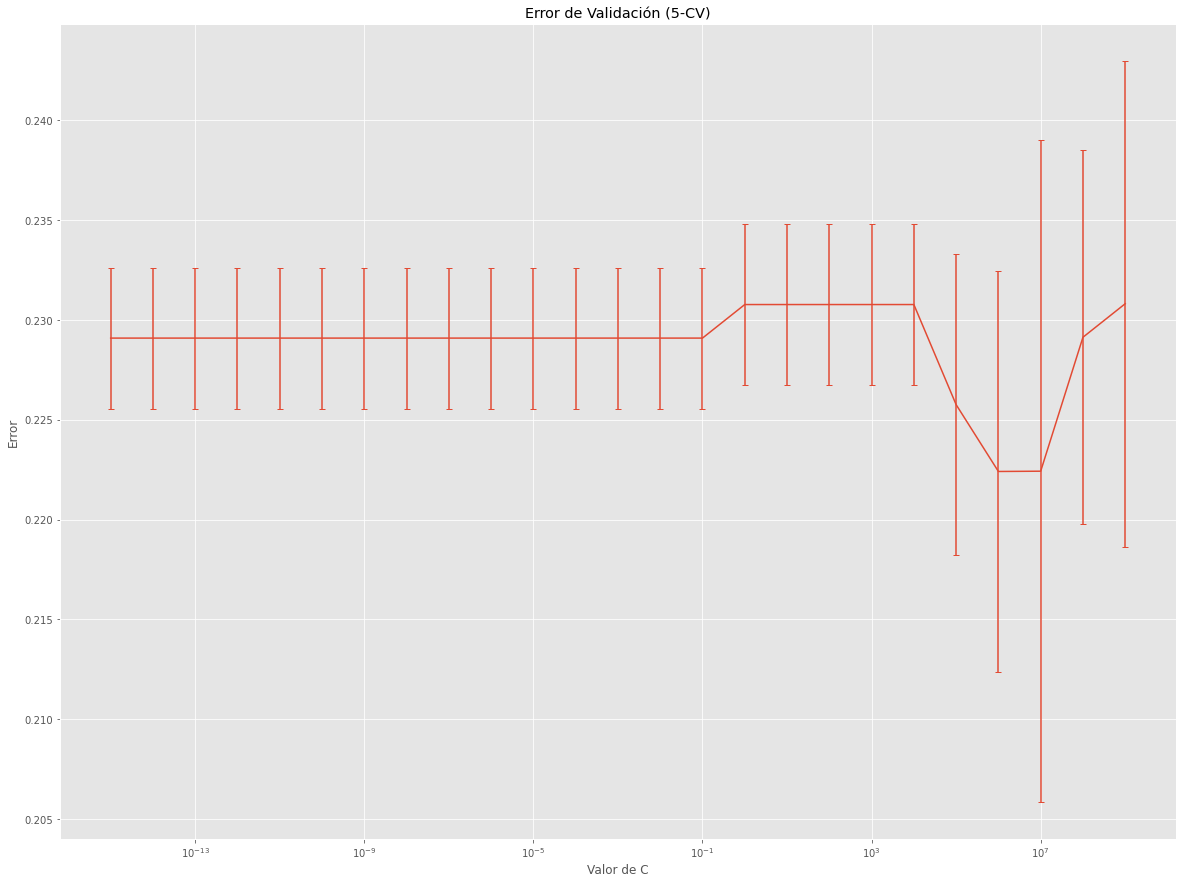

In [51]:
# Set up the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Graph
ax.set_title(f"Error de Validación (5-CV)")
ax.set_xlabel("Valor de C")
ax.set_ylabel("Error")
ax.set_xscale('log', nonposx='clip')

ax.errorbar(
    cv_results_linear['param_C'],
    cv_results_linear['mean_test_score'],
    cv_results_linear['std_test_score'],
    capsize = 3
    )


Como se puede ver el error se estanca para valores de `C` menores que 0.1 y aunque sigamos disminuyendo este valor, se mantendrá igual el error de entrenamiento. También hay que tener en cuenta que a menor error de `C` el modelo es más sencillo, por lo que escogeremos como mejor parámetro el menor valor de `C` con el que experimentaremos.

Sin embargo, para valores de `C` mayores a 10e04 el error de entrenamiento empieza a bajar llegando a su mínimo para `C` igual a 10e06. A partir de 10e07 vuelve a subir de nuevo.

El **menor error de validación cruzada**, **su desviación estándar** y el **hiper-parámetro para el que se consigue** es el siguiente:

In [53]:
cv_results_linear_best = cv_results_linear[cv_results_linear['rank_test_score'] == 1]

cv_results_linear_best.loc[:, [
    'param_C',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_C', 
    ascending=True
).head()


,param_C,mean_test_score,std_test_score,rank_test_score
21,1000000,0.222409,0.010032,1


**Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica del  error  de  entrenamiento  con  validación  cruzada  ha  hecho  una  buena  estimación  del  error de test.**

En primer lugar, debemos calcular el error de test frente al valor del hiper-parámetro `C`:

In [54]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_blood_transfusion_train_Y) + [0] * len(df_blood_transfusion_test_Y)
ps = PredefinedSplit(test_fold = split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_blood_transfusion_all_X_scaled = np.vstack(
    [df_blood_transfusion_train_X_scaled, df_blood_transfusion_test_X_scaled])
df_blood_transfusion_all_Y = pd.concat(
    [df_blood_transfusion_train_Y, df_blood_transfusion_test_Y])

svm = SVC(random_state = SEED_VALUE)
modelCV_linear_test = GridSearchCV(
    svm,
    hyperparameters_linear,
    cv=ps,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_linear_test.fit(df_blood_transfusion_all_X_scaled, df_blood_transfusion_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                               1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000, 100000, 1000000,
                               10000000, 100000000, 1000000000],
                         'kernel': ['linear']},
             return_train_score=True, scoring='accuracy')

Guardamos estos resultados y mostramos por pantalla:

In [55]:
test_results_linear = pd.DataFrame(modelCV_linear_test.cv_results_)
test_results_linear['mean_test_score'] = 1 - test_results_linear['mean_test_score']

test_results_linear.loc[:, [
    'param_C',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,mean_test_score,std_test_score,rank_test_score
24,1000000000,0.240000,0.0,1
22,10000000,0.253333,0.0,2
21,1000000,0.253333,0.0,2
23,100000000,0.253333,0.0,2
20,100000,0.266667,0.0,5
19,10000,0.273333,0.0,6
18,1000,0.273333,0.0,6
17,100,0.273333,0.0,6
16,10,0.273333,0.0,6
15,1,0.273333,0.0,6


En la siguiente gráfica mostraremos el error de test frente al error de entrenamiento para los diferentes valores del hiper-parámetro `C`:

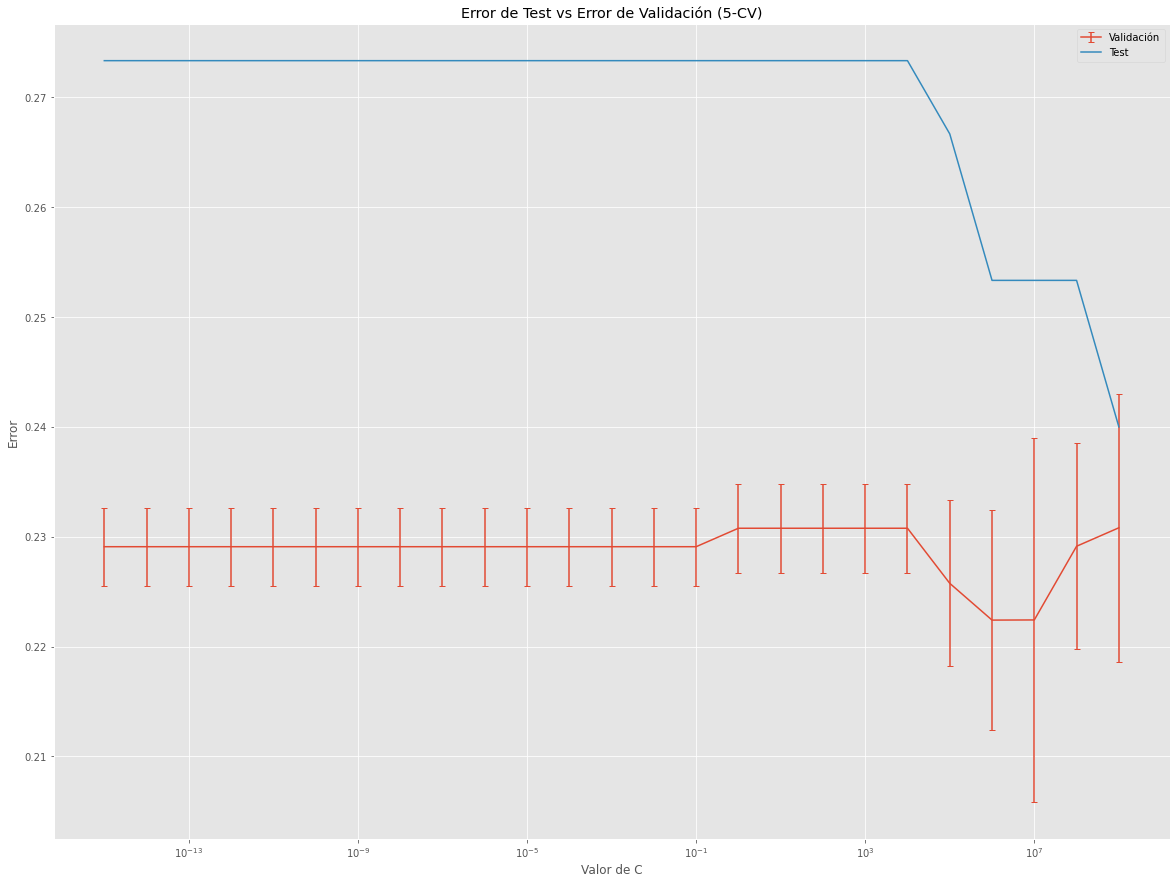

In [56]:
# Set up the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Graph
ax.set_title("Error de Test vs Error de Validación (5-CV)")
ax.set_xlabel("Valor de C")
ax.set_ylabel("Error")
ax.set_xscale('log', nonposx='clip')

ax.errorbar(
    cv_results_linear['param_C'],
    cv_results_linear['mean_test_score'],
    cv_results_linear['std_test_score'],
    label='Validación',
    capsize = 3
    )
ax.errorbar(
    test_results_linear['param_C'],
    test_results_linear['mean_test_score'],
    label='Test',
    capsize = 3
    )

ax.legend(loc="upper right")


El error de entrenamiento no hace una buena aproximación del error de test, dándose valores bastante más optimistas que los que nos muestra el error de test real.

**¿Cuál es el menor error de test y el valor de los hiper-parámetros para el que se consigue?**

El **menor error de test** se consigue para los siguientes valores de los hiper-parámetros:

In [57]:
test_results_linear_best = test_results_linear[test_results_linear['rank_test_score'] == 1]

test_results_linear_best.loc[:, [
    'param_C',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_C',
    ascending=True
).head()


,param_C,mean_test_score,std_test_score,rank_test_score
24,1000000000,0.24,0.0,1


**¿Cuál es el error de test para el valor de los hiper-parámetros seleccionados por la validación cruzada?**

El error de test para el valor seleccionado por la validación cruzada es:

In [58]:
# Cambiar el índice de forma acorde al resultado de la validación cruzada
test_results_cv_linear_error = float(test_results_linear.iloc[21]['mean_test_score'])
test_results_cv_linear_error
               

0.2533333333333333

#### Kernel 'poly'

En primer lugar definimos los hiper-parámetros a utilizar para este kernel. Empezaremos con una búsqueda de grano grueso para no elevar demasiado los tiempos de entrenamiento y después una de grano fino:

In [59]:
# Para los tres kernels
c = [10**i for i in range(-8, 0, 2)]

# Para el kernel poly
degree = range(2, 7, 2)

hyperparameters_poly = {
    'kernel': ['poly'],
    'C': c,
    'gamma': [1],
    'degree': degree
}


Ahora seguiremos con este mismo entrenamiento haciendo uso del **kernel 'poly'**:

In [60]:
svm = SVC(random_state = SEED_VALUE)
modelCV_poly = GridSearchCV(
    svm,
    hyperparameters_poly,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_poly.fit(df_blood_transfusion_train_X_scaled, df_blood_transfusion_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-08, 1e-06, 0.0001, 0.01],
                         'degree': range(2, 7, 2), 'gamma': [1],
                         'kernel': ['poly']},
             return_train_score=True, scoring='accuracy')

Después consultaremos los resultados obtenidos, mostrando un ranking con los mejores resultados ordenados de mejor a peor:

In [61]:
cv_results_poly = pd.DataFrame(modelCV_poly.cv_results_)
cv_results_poly['mean_test_score'] = 1 - cv_results_poly['mean_test_score']

cv_results_poly.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
10,0.01,4,0.227423,0.003074,1
4,1e-06,4,0.227437,0.006614,2
0,1e-08,2,0.229090,0.003533,3
3,1e-06,2,0.229090,0.003533,3
6,0.0001,2,0.229090,0.003533,3
2,1e-08,6,0.229104,0.004354,6
7,0.0001,4,0.229104,0.004354,6
8,0.0001,6,0.230756,0.006143,8
1,1e-08,4,0.230770,0.004048,9
9,0.01,2,0.230770,0.008482,10


El valor del hiper-parámetro `degree` nos indica el grado de la función de kernel polinomial a ser utilizada. Como se puede ver, los mejores resultados se obtienen para valores de entre 2 y 4 para el valor del hiper-parámetro `degree`, por lo que haremos una nueva búsqueda para más valores de `C` y este rango de valores para `degree`:

In [62]:
# Para los tres kernels
c = [10**i for i in range(-8, 4, 1)]

# Para el kernel poly
degree = range(2, 5, 1)

hyperparameters_poly = {
    'kernel': ['poly'],
    'C': c,
    'gamma': [1],
    'degree': degree
}

svm = SVC(random_state = SEED_VALUE)
modelCV_poly = GridSearchCV(
    svm,
    hyperparameters_poly,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_poly.fit(df_blood_transfusion_train_X_scaled, df_blood_transfusion_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000],
                         'degree': range(2, 5), 'gamma': [1],
                         'kernel': ['poly']},
             return_train_score=True, scoring='accuracy')

Obteniendo como resultado el siguiente:

In [63]:
cv_results_poly = pd.DataFrame(modelCV_poly.cv_results_)
cv_results_poly['mean_test_score'] = 1 - cv_results_poly['mean_test_score']

cv_results_poly.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
16,0.001,3,0.224090,0.006537,1
26,1,4,0.224090,0.003807,1
32,100,4,0.224090,0.008369,1
13,0.0001,3,0.225756,0.007542,4
29,10,4,0.225756,0.005351,4
30,100,2,0.225756,0.007542,4
10,1e-05,3,0.225756,0.007542,4
27,10,2,0.225756,0.007542,4
5,1e-07,4,0.225756,0.007542,4
33,1000,2,0.225756,0.007542,4


Almacenamos el modelo para su uso posterior:

In [85]:
joblib.dump(modelCV_poly, 'models/blood_transfusion_poly.joblib')


['models/blood_transfusion_poly.joblib']

**Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor del hiper-parámetro.**

Mostramos la gráfica del error de entrenamiento frente al valor del hiper-parámetro `C`. En este caso, como estamos usando el kernel `poly` o polinomial debemos representar la gráfica frente a `C` para los valores de `degree` que consideremos más representativos. Al tener únicamente 3 valores para el hiper-parámetro `degree` mostraremos en la gráfica los resultados para todos ellos:

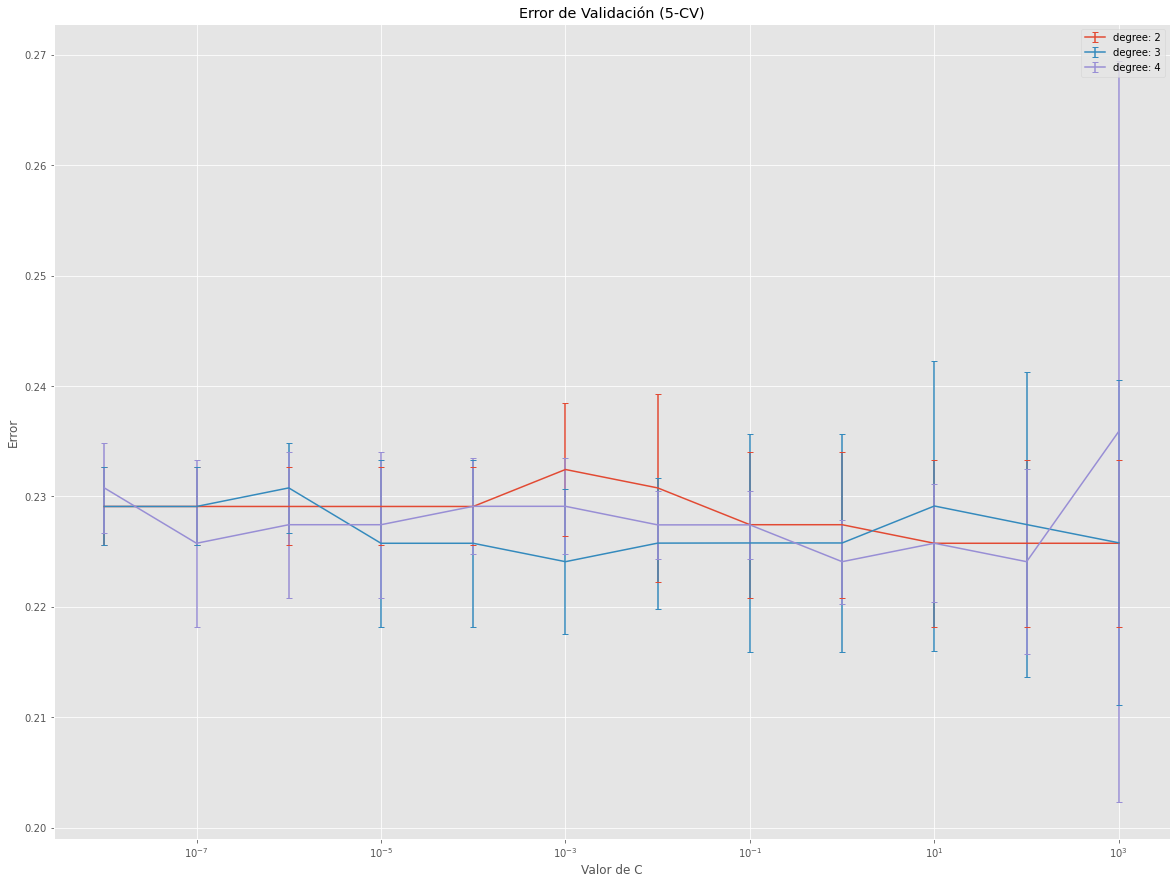

In [66]:
# Set up the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Graph
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de C")
ax.set_ylabel("Error")
ax.set_xscale('log', nonposx='clip')

# Graph for every combination of number of layers and value of alpha
for degree in hyperparameters_poly['degree']:
    cv_results_poly_degree = cv_results_poly[cv_results_poly['param_degree'] == degree]

    ax.errorbar(
        cv_results_poly_degree['param_C'],
        cv_results_poly_degree['mean_test_score'],
        cv_results_poly_degree['std_test_score'],
        label=f'degree: {degree}',
        capsize = 3
        )
    ax.legend(loc='upper right')


Como se puede ver en la gráfica superior, los mejores valores se encuentran para los valores de `degree` de 3 y de 4. Si se siguen aumentando los valores de `C` y de `degree`, los cuales nos llevan a modelos más complejos. Los tiempos de entrenamiento aumentan muchísimo, llegando en alguna de las pruebas que fue ejecutada a tener que detener los entrenamientos por estar llevando más de 1h su ejecución. Es por esto y porque estos mayores valores de los hiper-parámetros también generan modelos más complejos y que tienden al sobre-aprendizaje, que se decidió que el mejor resultado del entrenamiento aquí mostrado sea el que usaremos a continuación.

El **menor error de validación cruzada**, **su desviación estándar** y el **hiper-parámetro para el que se consigue** es el siguiente:

In [67]:
cv_results_poly_best = cv_results_poly[cv_results_poly['rank_test_score'] == 1]

cv_results_poly_best.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_C', 
    ascending=True
).head()


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
16,0.001,3,0.22409,0.006537,1
26,1,4,0.22409,0.003807,1
32,100,4,0.22409,0.008369,1


**Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica del  error  de  entrenamiento  con  validación  cruzada  ha  hecho  una  buena  estimación  del  error de test**

En primer lugar, debemos calcular el error de test frente al valor de los hiper-parámetros:

In [68]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_blood_transfusion_train_Y) + [0] * len(df_blood_transfusion_test_Y)
ps = PredefinedSplit(test_fold = split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_blood_transfusion_all_X_scaled = np.vstack(
    [df_blood_transfusion_train_X_scaled, df_blood_transfusion_test_X_scaled])
df_blood_transfusion_all_Y = pd.concat(
    [df_blood_transfusion_train_Y, df_blood_transfusion_test_Y])

svm = SVC(random_state = SEED_VALUE)
modelCV_poly_test = GridSearchCV(
    svm,
    hyperparameters_poly,
    cv=ps,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_poly_test.fit(df_blood_transfusion_all_X_scaled, df_blood_transfusion_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000],
                         'degree': range(2, 5), 'gamma': [1],
                         'kernel': ['poly']},
             return_train_score=True, scoring='accuracy')

Guardamos estos resultados y los mostramos por pantalla:

In [69]:
test_results_poly = pd.DataFrame(modelCV_poly_test.cv_results_)
test_results_poly['mean_test_score'] = 1 - test_results_poly['mean_test_score']

test_results_poly.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
35,1000,4,0.246667,0.0,1
34,1000,3,0.246667,0.0,1
32,100,4,0.253333,0.0,3
31,100,3,0.253333,0.0,3
29,10,4,0.253333,0.0,3
28,10,3,0.253333,0.0,3
25,1,3,0.253333,0.0,3
22,0.1,3,0.253333,0.0,3
19,0.01,3,0.253333,0.0,3
30,100,2,0.266667,0.0,10


En las siguientes gráficas mostramos el error de test frente al error de entrenamiento en función del valor del hiper-parámetro `C`. En cada una de las gráficas representaremos los resultados obtenidos para un valor específico del hiper-parámetro `degree`:

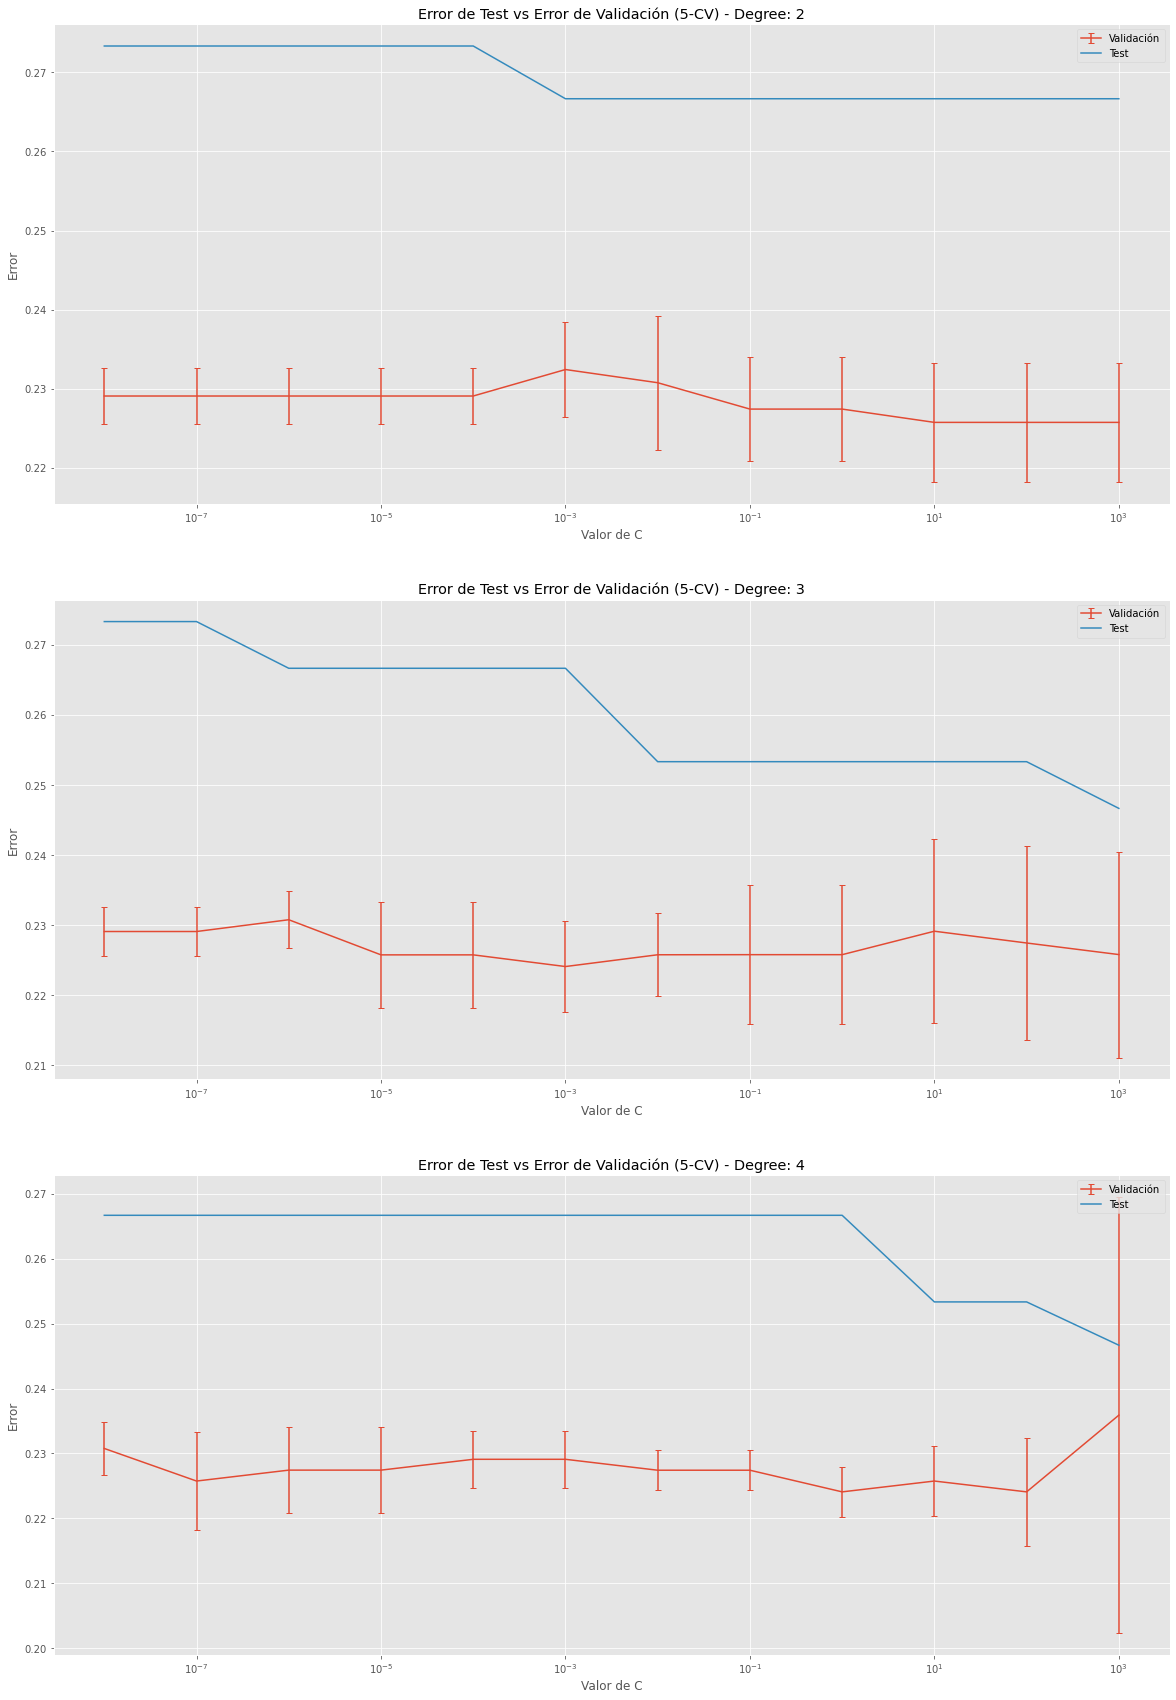

In [70]:
# Set up the graph
fig, axes = plt.subplots(figsize=(20, 30), nrows=len(hyperparameters_poly['degree']))

counter = 0

for degree in hyperparameters_poly['degree']:
    cv_results_poly_degree = cv_results_poly[cv_results_poly['param_degree'] == degree]
    test_results_poly_degree = test_results_poly[test_results_poly['param_degree'] == degree]

    # Graph
    axes[counter].set_title(f"Error de Test vs Error de Validación (5-CV) - Degree: {degree}")
    axes[counter].set_xlabel("Valor de C")
    axes[counter].set_ylabel("Error")
    axes[counter].set_xscale('log', nonposx='clip')

    axes[counter].errorbar(
        cv_results_poly_degree['param_C'],
        cv_results_poly_degree['mean_test_score'],
        cv_results_poly_degree['std_test_score'],
        label='Validación',
        capsize = 3
        )
    axes[counter].errorbar(
        test_results_poly_degree['param_C'],
        test_results_poly_degree['mean_test_score'],
        label='Test',
        capsize = 3
        )

    axes[counter].legend(loc="upper right")

    counter += 1
    

Como se puede ver en las gráficas superiores, el error de entrenamiento no apróxima muy bien los errores de test para los mismos valores de los hiper-parámetros. Además, se puede ver como el error de test decrece cuando aumenta el valor de `C`, mientras que en el error de entrenamiento esto no pasa.


**¿Cuál es el menor error de test y el valor de los hiper-parámetros para el que se consigue?**

El **menor error de test** se consigue para los siguientes valores de los hiper-parámetros:

In [72]:
test_results_poly_best = test_results_poly[test_results_poly['rank_test_score'] == 1]

test_results_poly_best.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_C',
    ascending=True
).head()


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
34,1000,3,0.246667,0.0,1
35,1000,4,0.246667,0.0,1


**¿Cuál es el error de test para el valor de los hiper-parámetros seleccionados por la validación cruzada?**

El error de test para el valor seleccionado por la validación cruzada es:

In [74]:
# Cambiar el índice de forma acorde al resultado de la validación cruzada
test_results_cv_poly_error = float(test_results_poly.iloc[16]['mean_test_score'])
test_results_cv_poly_error


0.2666666666666667

#### Kernel 'rbf'

De nuevo, lo primero es definir los hiper-parámetros con los que entrenaremos para el uso de este kernel. Al igual que antes empezaremos con una búsqueda de grano grueso para ver en que rango de valores para los hiper-parámetros se obtienen los mejores resultados y también para que valores los tiempos de entrenamiento empiezan a hacerse demasiado grandes, y por tanto imposibles de ser estudiados. Después de esta búsqueda, llevaremos a cabo otra de grano más fino. 

Lo primero, como siempre, es definir los hiper-parámetros que vamos a utilizar para ejecutar el entenamiento:

In [75]:
# Para los tres kernels
c = [10**i for i in range(-8, 0, 2)]

# Para el kernel rbf
gamma = [10**i for i in range(-8, 6, 2)]

hyperparameters_rbf = {
    'kernel': ['rbf'],
    'C': c,
    'gamma': gamma
}


Ahora ejecutamos el entrenamiento haciendo uso del **kernel 'rbf'**:

In [76]:
svm = SVC(random_state = SEED_VALUE)
modelCV_rbf = GridSearchCV(
    svm,
    hyperparameters_rbf,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_rbf.fit(df_blood_transfusion_train_X_scaled, df_blood_transfusion_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-08, 1e-06, 0.0001, 0.01],
                         'gamma': [1e-08, 1e-06, 0.0001, 0.01, 1, 100, 10000],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

A continuación consultamos los resultados obtenidos, mostrando un ranking con los mejores resultados ordenados de mejor a peor:

In [77]:
cv_results_rbf = pd.DataFrame(modelCV_rbf.cv_results_)
cv_results_rbf['mean_test_score'] = 1 - cv_results_rbf['mean_test_score']

cv_results_rbf.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
0,1e-08,1e-08,0.22909,0.003533,1
25,0.01,1,0.22909,0.003533,1
24,0.01,0.01,0.22909,0.003533,1
23,0.01,0.0001,0.22909,0.003533,1
22,0.01,1e-06,0.22909,0.003533,1
21,0.01,1e-08,0.22909,0.003533,1
20,0.0001,10000,0.22909,0.003533,1
19,0.0001,100,0.22909,0.003533,1
18,0.0001,1,0.22909,0.003533,1
17,0.0001,0.01,0.22909,0.003533,1


Tras algunas pruebas de ejecución de este entrenamiento, se comprueba que el valor del hiper-parámetro `gamma` no influye en gran medida en los tiempos de entrenamiento de nuestro modelo. Sin embargo, a medida que aumenta el valor de `C` los tiempos de entrenamiento sí que aumentan en una medida muy grande. 

El valor de `gamma` nos indica cómo de lejos llega la influencia de uno de los ejemplos del conjunto de entrenamiento, con los valores bajos de `gamma` significando 'lejos' y los valores grandes significando 'cerca'. El hiper-parámetro `gamma` se puede entender como el inverso del radio de influencia de las observaciones escogidas por el modelo como vectores de soporte. 

Como se puede ver, los mejores resultados se obtienen para valores de `gamma` inferiores a 1, por lo que haremos la búsqueda con más detalle para los valores de `C`, en este rango para los valores del hiper-parámetro `gamma`.

Por lo tanto ahora haremos un búsqueda con un grano más fino y para más valores del hiper-parámetro `C`:

In [78]:
# Para los tres kernels
c = [10**i for i in range(-8, 10, 1)]

# Para el kernel rbf
gamma = [10**i for i in range(-8, 2, 1)]

hyperparameters_rbf = {
    'kernel': ['rbf'],
    'C': c,
    'gamma': gamma
}

svm = SVC(random_state = SEED_VALUE)
modelCV_rbf = GridSearchCV(
    svm,
    hyperparameters_rbf,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_rbf.fit(df_blood_transfusion_train_X_scaled, df_blood_transfusion_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000, 100000, 1000000,
                               10000000, 100000000, 1000000000],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

Obteniendo el resultado siguiente:

In [79]:
cv_results_rbf = pd.DataFrame(modelCV_rbf.cv_results_)
cv_results_rbf['mean_test_score'] = 1 - cv_results_rbf['mean_test_score']

cv_results_rbf.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
165,100000000,0.001,0.209090,0.026400,1
154,10000000,0.0001,0.210756,0.024944,2
155,10000000,0.001,0.212465,0.033469,3
164,100000000,0.0001,0.215770,0.019947,4
136,100000,0.01,0.215784,0.023295,5
...,...,...,...,...,...
158,10000000,1,0.306106,0.022728,176
138,100000,1,0.307675,0.019747,177
178,1000000000,1,0.307759,0.024668,178
177,1000000000,0.1,0.307759,0.046701,178


Almacenamos el modelo para su uso posterior:

In [86]:
joblib.dump(modelCV_rbf, 'models/blood_transfusion_rbf.joblib')


['models/blood_transfusion_rbf.joblib']

**Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor del hiper-parámetro.**

Mostramos la gráfica del error de entrenamiento frente al valor del hiper-parámetro `C`. En este caso, como estamos usando el kernel `rbf` debemos representar la gráfica frente a los valores de `C` para los valores de `gamma` más representativos. Los valores de `gamma` que mejores resultados nos dieron en el apartado anterior son los que se encuentran entre 1e-05 y 1e-01, por lo que representaremos para estos valores:

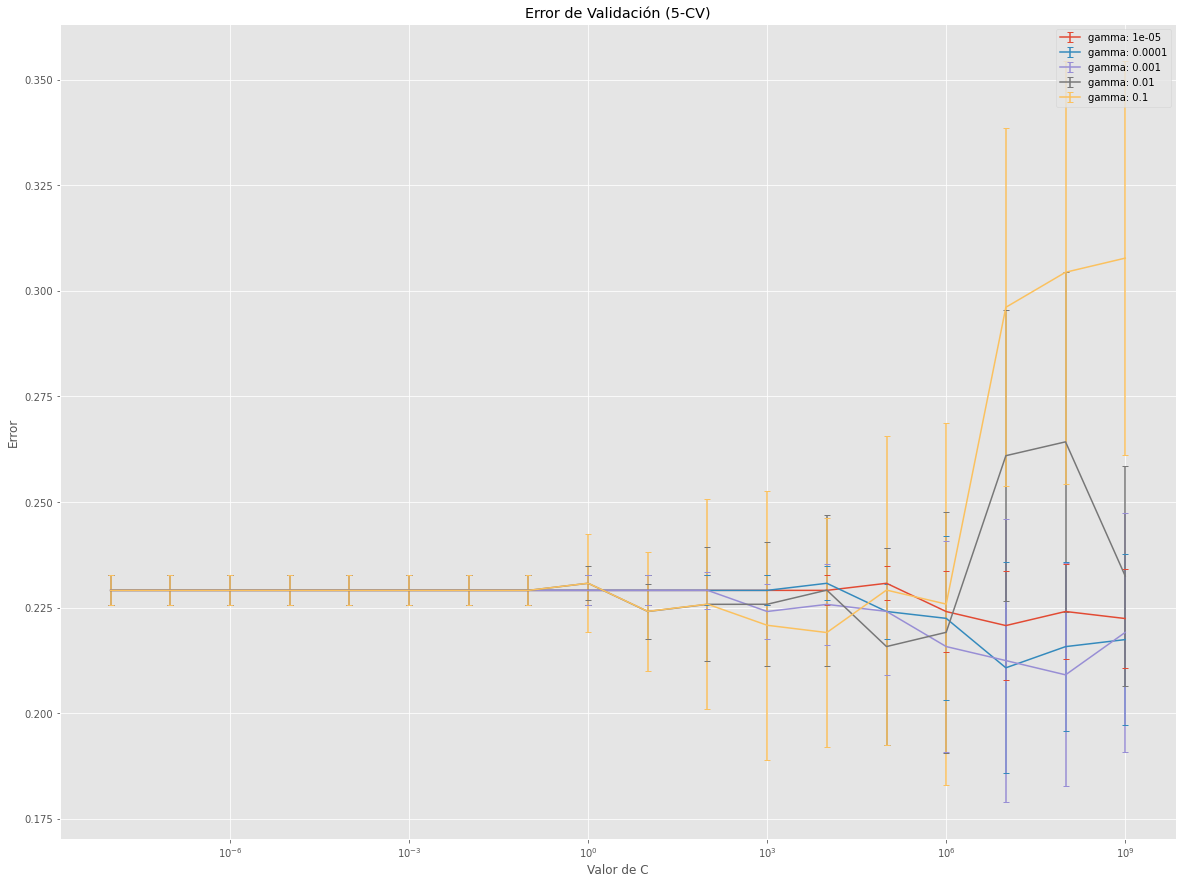

In [80]:
# Set up the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Graph
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de C")
ax.set_ylabel("Error")
ax.set_xscale('log', nonposx='clip')

# Graph for every combination of number of layers and value of alpha
for gamma in [10**i for i in range(-5, 0, 1)]:
    cv_results_rbf_gamma = cv_results_rbf[cv_results_rbf['param_gamma'] == gamma]

    ax.errorbar(
        cv_results_rbf_gamma['param_C'],
        cv_results_rbf_gamma['mean_test_score'],
        cv_results_rbf_gamma['std_test_score'],
        label=f'gamma: {gamma}',
        capsize = 3
        )
    ax.legend(loc='upper right')


Se puede ver como los valores del error de entrenamiento son relativamente estables para los valores de `C` inferiores a 10e03, sin embargo a partir de este valor se ve como los errores de entrenamiento empiezan a fluctuar más, obteniendose los mejores valores para los valores de `C` de 10e07 y 10e08, y empezando a subir después, sobre todo para los valores de `gamma` que presentan los mejores resultados. Juntando esto con que los tiempos de entrenamiento aumentan mucho al seguir aumentando los valores del hiper-parámetro `C`, no se hicieron entrenamientos para valores mayores.

El **menor error de validación cruzada**, **su desviación estándar** y el **hiper-parámetro para el que se consigue** es el siguiente:

In [81]:
cv_results_rbf_best = cv_results_rbf[cv_results_rbf['rank_test_score'] == 1]

cv_results_rbf_best.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_C', 
    ascending=True
).head()


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
165,100000000,0.001,0.20909,0.0264,1


**Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica del  error  de  entrenamiento  con  validación  cruzada  ha  hecho  una  buena  estimación  del  error de test**

En primer lugar, debemos calcular el error de test frente al valor de los hiper-parámetros:

In [87]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_blood_transfusion_train_Y) + [0] * len(df_blood_transfusion_test_Y)
ps = PredefinedSplit(test_fold = split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_blood_transfusion_all_X_scaled = np.vstack(
    [df_blood_transfusion_train_X_scaled, df_blood_transfusion_test_X_scaled])
df_blood_transfusion_all_Y = pd.concat(
    [df_blood_transfusion_train_Y, df_blood_transfusion_test_Y])

svm = SVC(random_state = SEED_VALUE)
modelCV_rbf_test = GridSearchCV(
    svm,
    hyperparameters_rbf,
    cv=ps,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_rbf_test.fit(df_blood_transfusion_all_X_scaled, df_blood_transfusion_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000, 100000, 1000000,
                               10000000, 100000000, 1000000000],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

Mostramos los resultados obtenidos por pantalla:

In [88]:
test_results_rbf = pd.DataFrame(modelCV_rbf_test.cv_results_)
test_results_rbf['mean_test_score'] = 1 - test_results_rbf['mean_test_score']

test_results_rbf.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
145,1000000,0.001,0.206667,0.0,1
107,100,0.1,0.213333,0.0,2
88,1,1,0.220000,0.0,3
117,1000,0.1,0.220000,0.0,3
136,100000,0.01,0.220000,0.0,3
...,...,...,...,...,...
148,1000000,1,0.300000,0.0,175
157,10000000,0.1,0.313333,0.0,177
168,100000000,1,0.313333,0.0,177
167,100000000,0.1,0.333333,0.0,179


En las siguientes gráficas mostramos el error de test frente al error de entrenamiento en función del valor del hiper-parámetro `C`. En cada una de ellas representaremos los resultados para los valores del hiper-parámetro `gamma` más representativos (entre 1e-05 y 1e-01):

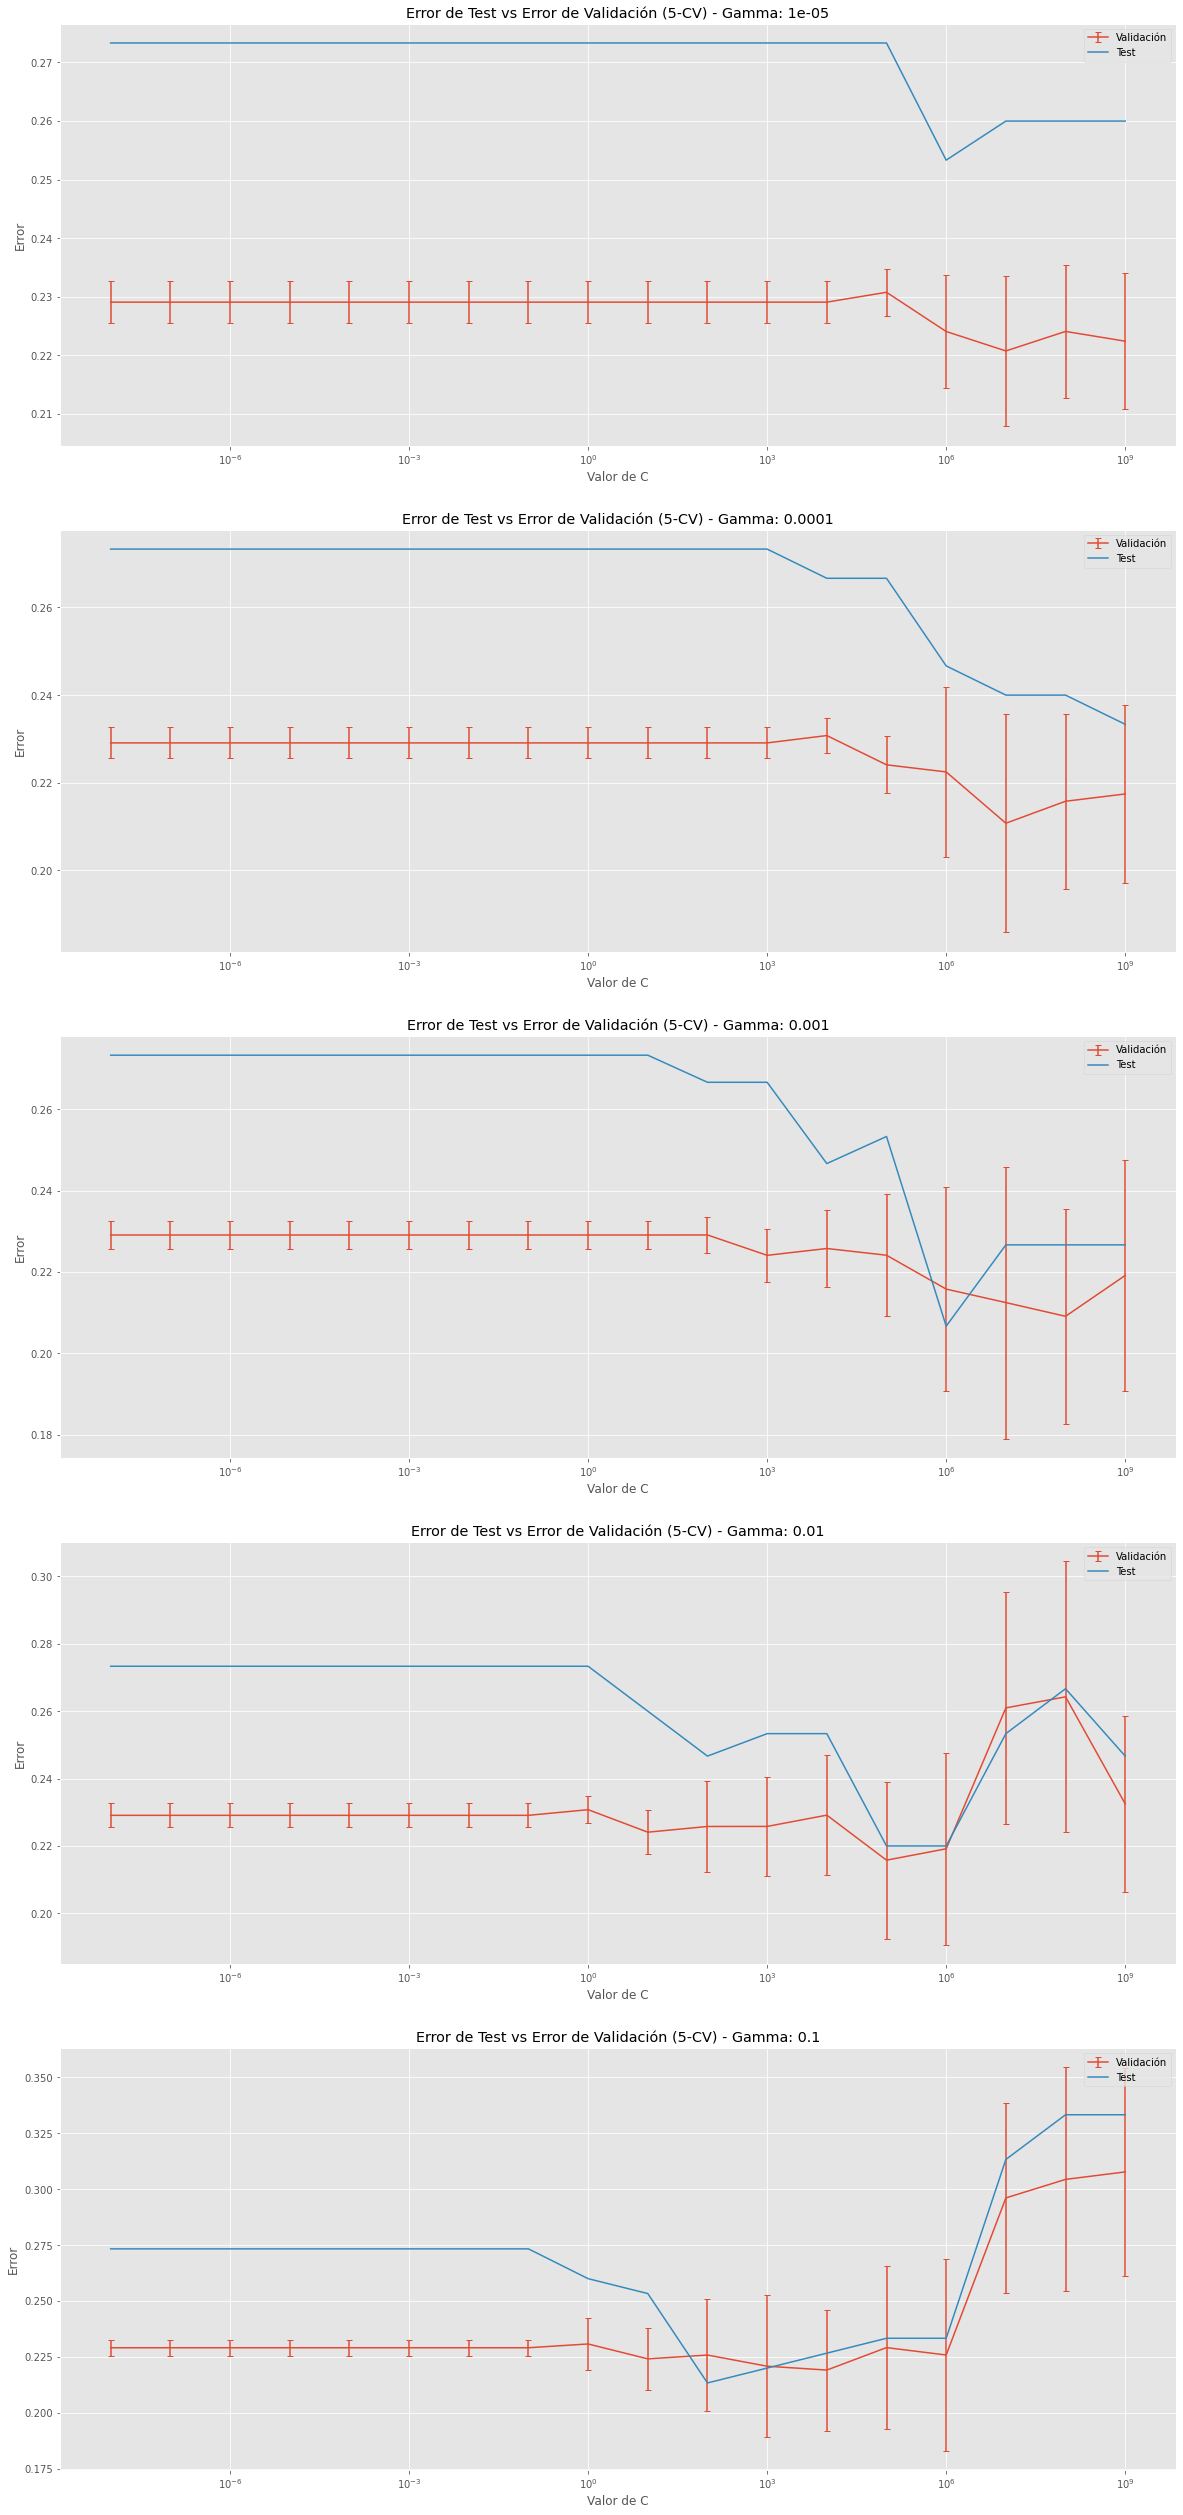

In [89]:
gammas_to_plot = [10**i for i in range(-5, 0, 1)]

# Set up the graph
fig, axes = plt.subplots(figsize=(20, 45), nrows=len(gammas_to_plot))

counter = 0

for gamma in gammas_to_plot:
    cv_results_rbf_gamma = cv_results_rbf[cv_results_rbf['param_gamma'] == gamma]
    test_results_rbf_gamma = test_results_rbf[test_results_rbf['param_gamma'] == gamma]

    # Graph
    axes[counter].set_title(f"Error de Test vs Error de Validación (5-CV) - Gamma: {gamma}")
    axes[counter].set_xlabel("Valor de C")
    axes[counter].set_ylabel("Error")
    axes[counter].set_xscale('log', nonposx='clip')

    axes[counter].errorbar(
        cv_results_rbf_gamma['param_C'],
        cv_results_rbf_gamma['mean_test_score'],
        cv_results_rbf_gamma['std_test_score'],
        label='Validación',
        capsize = 3
        )
    axes[counter].errorbar(
        test_results_rbf_gamma['param_C'],
        test_results_rbf_gamma['mean_test_score'],
        label='Test',
        capsize = 3
        )

    axes[counter].legend(loc="upper right")

    counter += 1


Antes de analizar las siguientes gráficas, cabe recordar que el valor del hiper-parámetro `gamma` nos indica cómo de lejos llega la influencia de cada una de las observaciones en el conjunto de entrenamiento. Con valores pequeños, significando 'lejos' y valores grandes significando 'cerca'.

Podemos ver en las gráficas superiores, como el error de entrenamiento aproxima el error de test de una forma muy acertada para los valores de `gamma` más altos (0.01 y 0.1), es decir, cuando la influencia de un ejemplo solo llega a puntos cercanos a él. Esto ocurre para los valores altos del hiper-parámetro `c`.

Para los valores más pequeños del hiper-parámetro `gamma` el error de entrenamiento no aproxima tan bien el error de test, haciendo de una peor forma cuanto menor es el valor de `gamma`, es decir, cuanto más lejos llega la influencia de cada punto en el conjunto de entrenamiento (situación de sub-aprendizaje).

**¿Cuál es el menor error de test y el valor de los hiper-parámetros para el que se consigue?**

El **menor error de test** se consigue para los siguientes valores de los hiper-parámetros:

In [90]:
test_results_rbf_best = test_results_rbf[test_results_rbf['rank_test_score'] == 1]

test_results_rbf_best.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_C',
    ascending=True
).head()


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
145,1000000,0.001,0.206667,0.0,1


**¿Cuál es el error de test para el valor de los hiper-parámetros seleccionados por la validación cruzada?**

El error de test para el valor seleccionado por la validación cruzada es:

In [92]:
# Cambiar el índice de forma acorde al resultado de la validación cruzada
test_results_cv_rbf_error = float(test_results_rbf.iloc[165]['mean_test_score'])
test_results_cv_rbf_error


0.22666666666666668

## Ejercicio 3

Ahora trabajaremos con el conjunto de datos [Pima Indians Diabetes](http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes).

### Apartado 0

Haremos un análisis rápido de las características de este nuevo conjunto de datos. En primer lugar leemos los datos del fichero de entrada:

In [93]:
df_pima_indians = pd.read_csv(
    'data/pima-indians-diabetes.data', 
    delimiter=',',
    skiprows=0,
    header=None,
    names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y"]
    )
    

Visualizamos las primeras filas para ver el número y el tipo de variables de entrada y salida:

In [94]:
df_pima_indians


,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


El número de instancias presentes en el DataFrame es el siguiente:

In [95]:
df_pima_indians.shape[0]


768

Comprobamos el tipo de dato de cada una de las columnas presentes en el DataFrame:

In [96]:
print('Tipo de dato de cada columna del Dataframe :')
print(df_pima_indians.dtypes)


Tipo de dato de cada columna del Dataframe :
X1      int64
X2      int64
X3      int64
X4      int64
X5      int64
X6    float64
X7    float64
X8      int64
Y       int64
dtype: object


Se puede ver que las columnas presentan valores numéricos (enteros o floats) en todos los casos. Comprobaremos si hay algún vallor perdido en el DataFrame:

In [97]:
print("Número de valores NaN en cada columna:")
df_pima_indians.isna().sum()


Número de valores NaN en cada columna:


X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y     0
dtype: int64

Vemos que no lo hay. Finalmente, estudiaremos el número de clases y la distribución de las mismas:

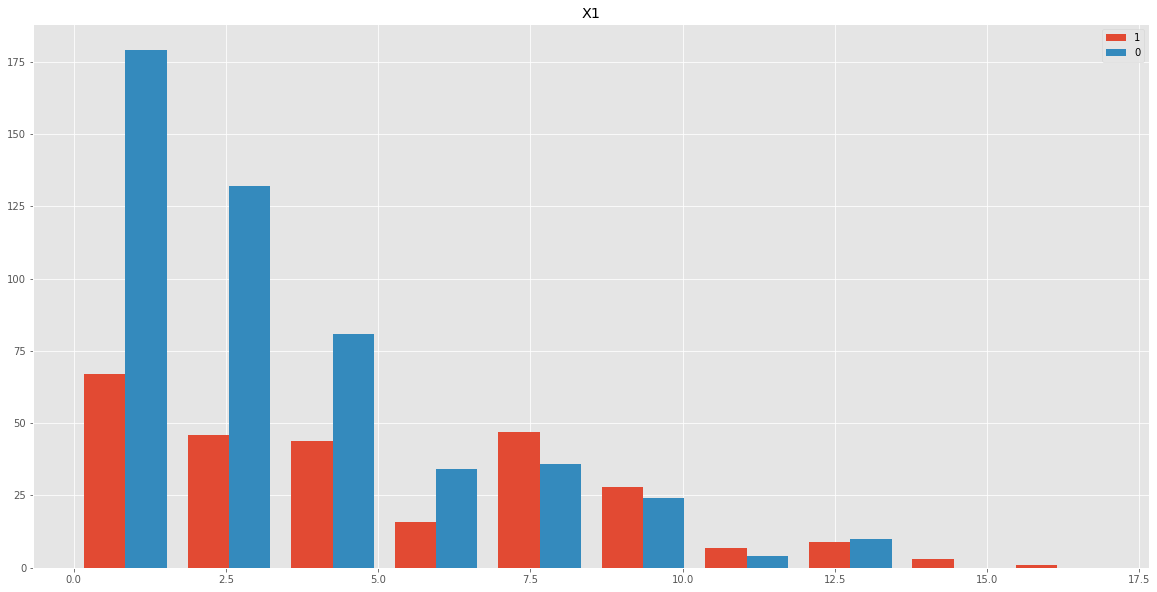

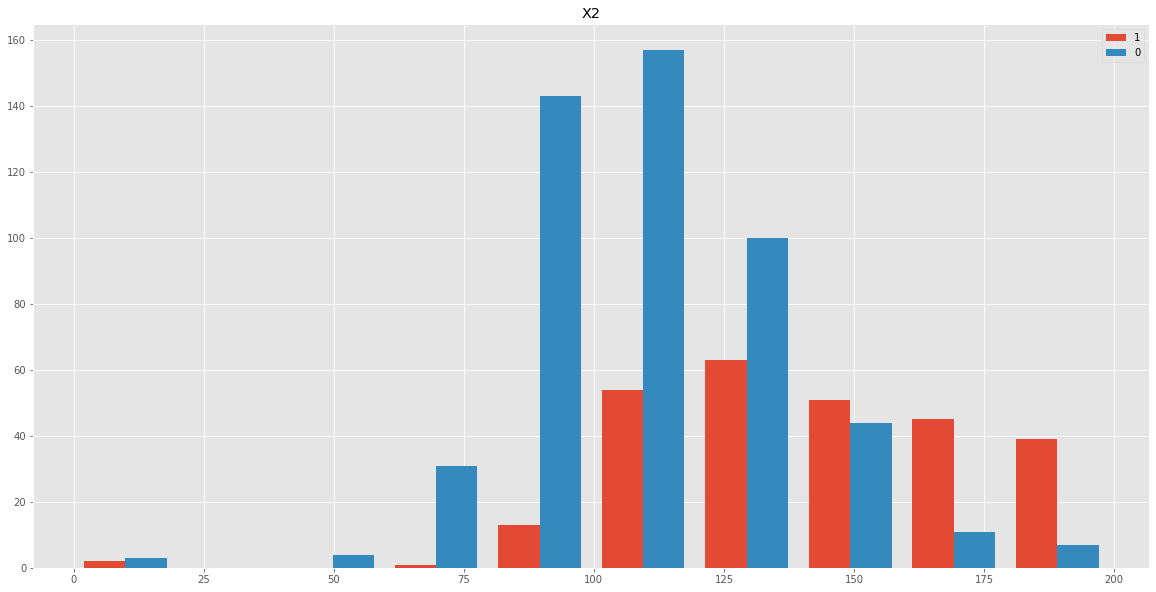

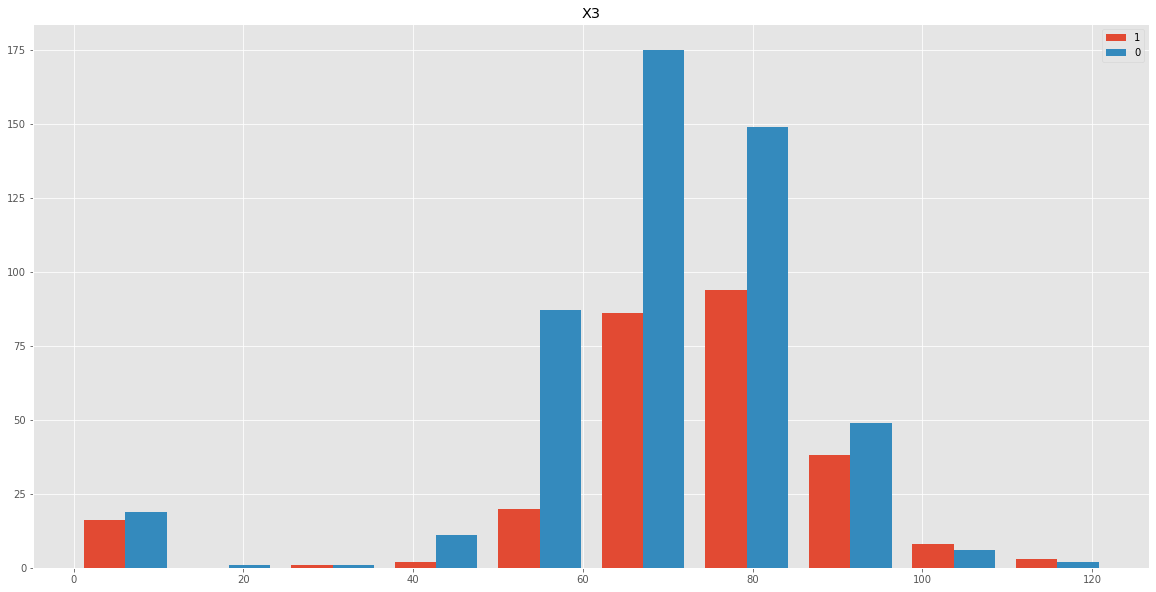

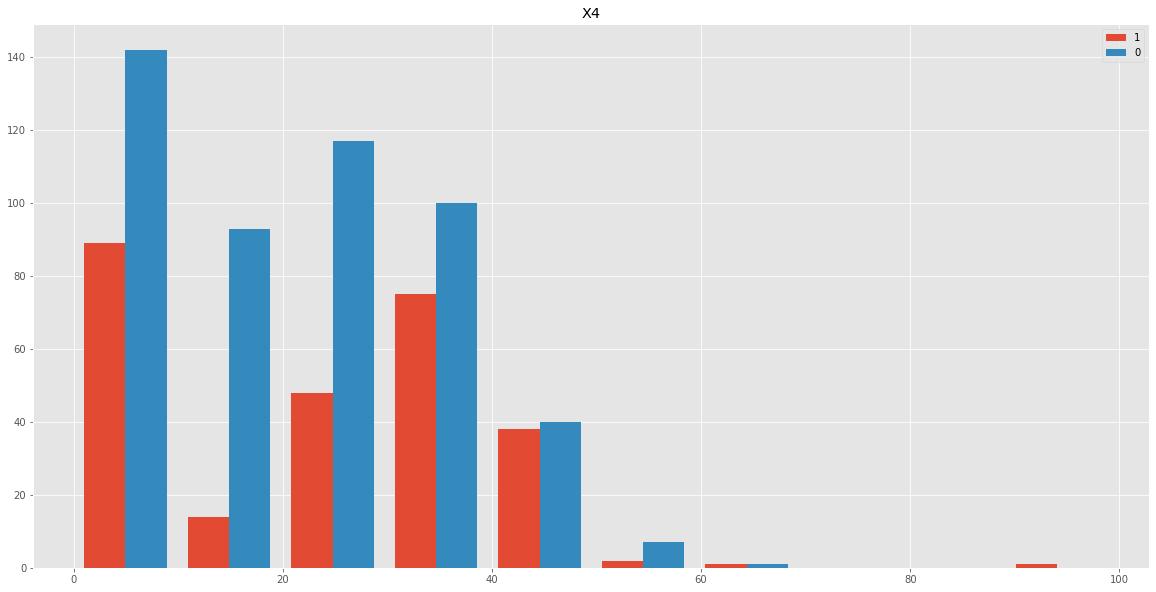

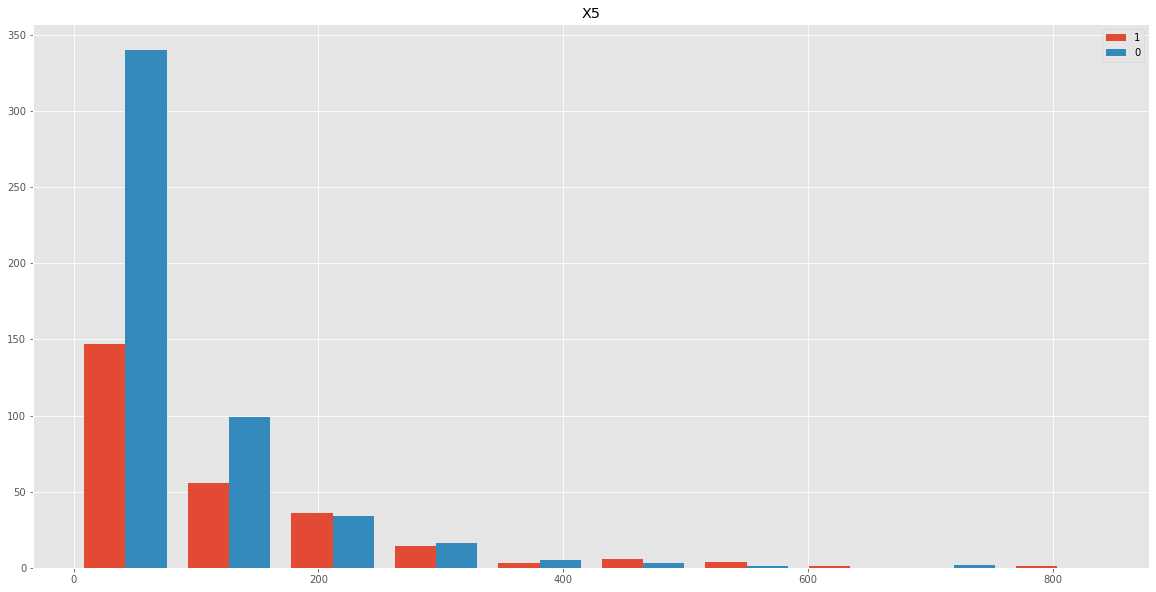

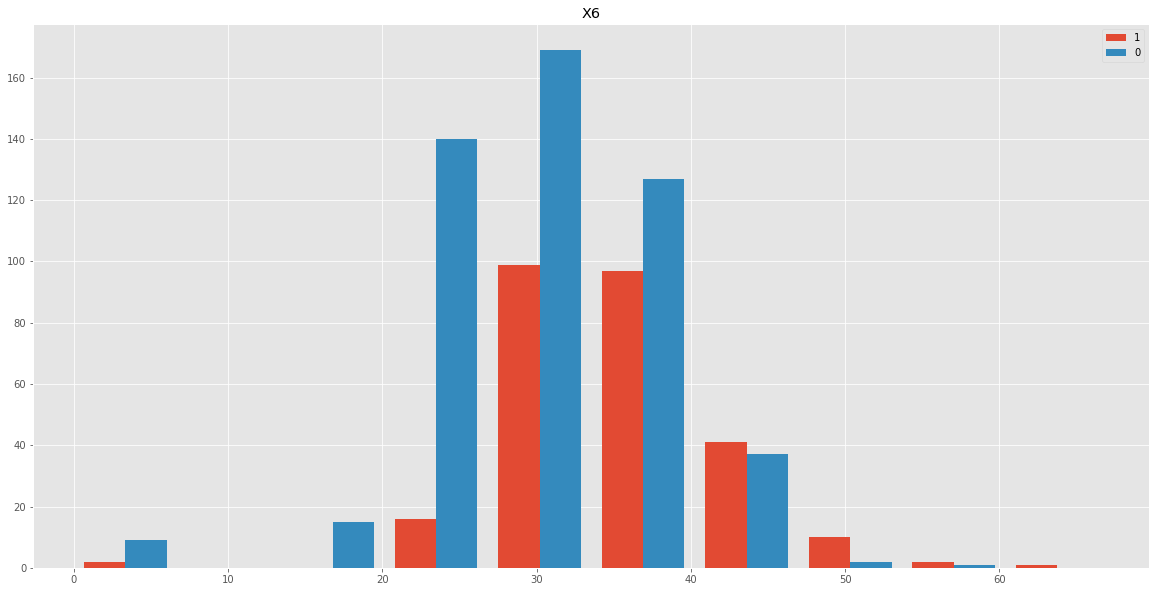

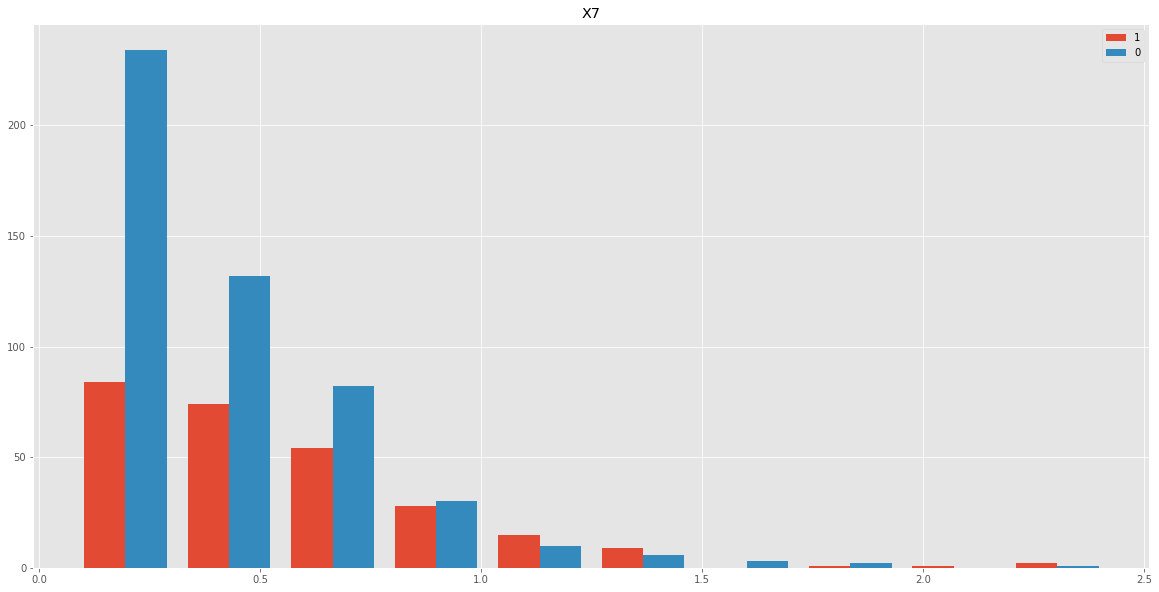

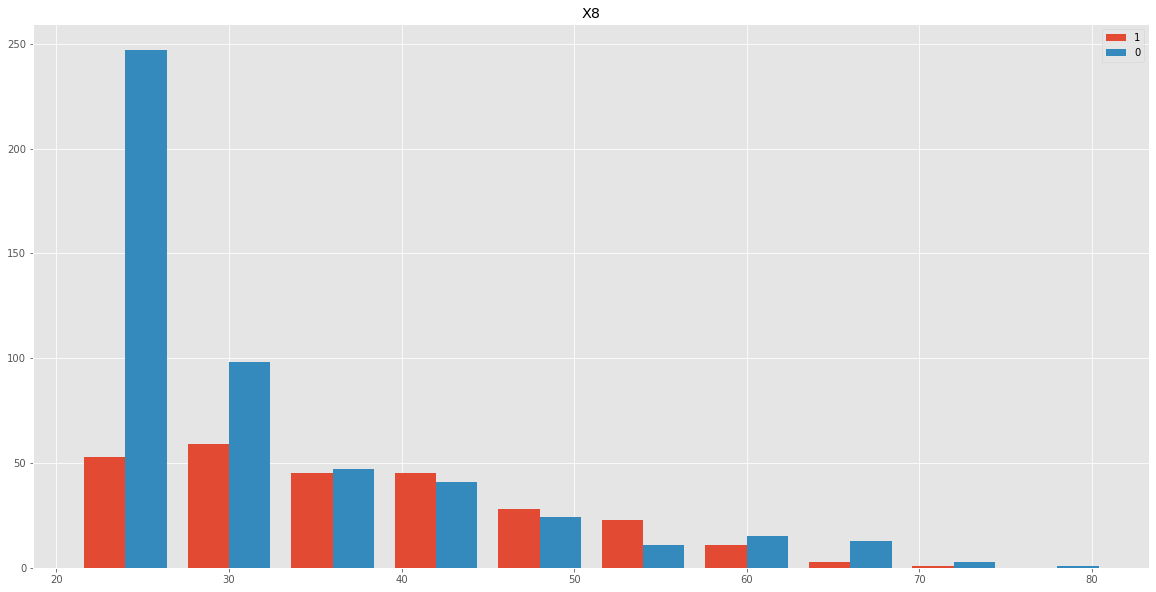

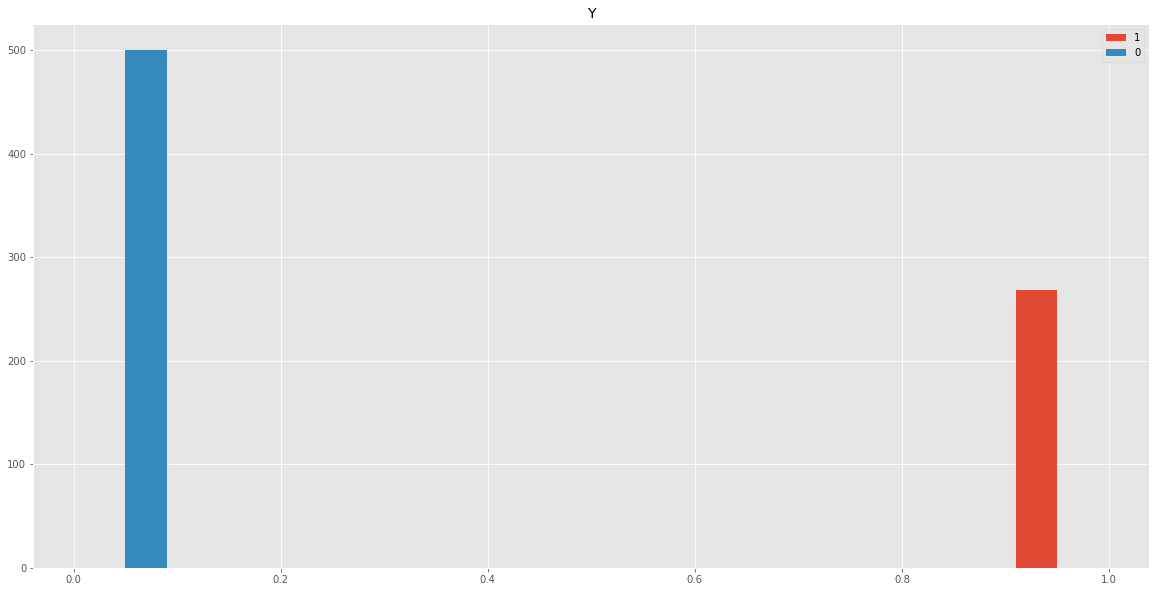

In [98]:
# Visualizamos la distribución de variables por clases
for column in df_pima_indians:
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title(column)
    ax.hist(
        [df_pima_indians[df_pima_indians['Y'] == 1][column], df_pima_indians[df_pima_indians['Y'] == 0][column]], 
        label=['1', '0']
    )
    ax.legend(loc='upper right')


Vemos como hay casi el doble de ejemplos de la categoría 0 que de la categoría 1 en nuestro dataset.

### Apartado a

**Una de las clases que implementa las Support Vector Machines (SVM) en problemas de clasificación en `scikit‐learn` es `sklearn.svm.SVC`. Revisa los parámetros y métodos que tiene.**

Se revisa la documentación de la clase `sklearn.svm.SVC` para entender los parámetros que tiene, qué hace cada uno, y los métodos que tiene, y cuál es la función de cada uno.

### Apartado b

**Divide los datos en entrenamiento (80%) y test (20%).**

Dividimos los datos en entrenamiento (80%) y test (20%) mediante este comando:

In [99]:
df_pima_indians_train, df_pima_indians_test = train_test_split(
    df_pima_indians,
    test_size = 0.2,
    random_state = SEED_VALUE
)


### Apartado c

**Realiza la experimentación con SVC usando los valores por defecto de los parámetros, excepto para los siguientes hiper-parámetros: kernel, degree, gamma y C**

En primer lugar, para llevar a cabo la experimentación con *SVC* es necesario que separemos las variables predictoras y dependientes:

In [100]:
df_pima_indians_train_X = df_pima_indians_train.loc[:, [
    'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].astype(float)
df_pima_indians_train_Y = df_pima_indians_train.loc[:, 'Y']

df_pima_indians_test_X = df_pima_indians_test.loc[:, [
    'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].astype(float)
df_pima_indians_test_Y = df_pima_indians_test.loc[:, 'Y']


Ahora llevaremos a cabo la estandarización de los datos, además, al ser un problema de clasificación **NO** es necesario que estandaricemos la variable dependiente:

In [101]:
scaler = StandardScaler()
scaler.fit(df_pima_indians_train_X)
df_pima_indians_train_X_scaled = scaler.transform(df_pima_indians_train_X)
df_pima_indians_test_X_scaled = scaler.transform(df_pima_indians_test_X)


Ahora que ya hemos acabado con el pre-procesado de los datos, podemos empezar con la experimentación.

Al igual que hicimos con el dataset Blood Transfusion Center, ejecutaremos el entrenamiento para cada uno de los **tres kernels** diferentes con los que tenemos que trabajar.

#### Kernel 'linear'

Establecemos los hiper-parámetros con los que trabajar:

In [102]:
# Para los tres kernels
c = [10**i for i in range(-15, 7, 1)]

hyperparameters_linear = {
    'kernel': ['linear'],
    'C': c
}


Entrenamos el modelo:

In [103]:
svm = SVC(random_state = SEED_VALUE)
modelCV_linear = GridSearchCV(
    svm,
    hyperparameters_linear,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_linear.fit(df_pima_indians_train_X_scaled, df_pima_indians_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                               1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
                         'kernel': ['linear']},
             return_train_score=True, scoring='accuracy')

Ahora podemos consultar los resultados obtenidos, mostrando un ranking con los mejores resultados ordenados de mejor a peor:

In [104]:
cv_results_linear = pd.DataFrame(modelCV_linear.cv_results_)
cv_results_linear['mean_test_score'] = 1 - cv_results_linear['mean_test_score']

cv_results_linear.loc[:, [
    'param_C',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,mean_test_score,std_test_score,rank_test_score
13,0.01,0.224750,0.003588,1
19,10000,0.229628,0.009132,2
14,0.1,0.229628,0.007547,2
18,1000,0.231254,0.010675,4
17,100,0.231254,0.010675,4
16,10,0.231254,0.010675,4
15,1,0.231267,0.008178,7
20,100000,0.232894,0.009597,8
21,1000000,0.241037,0.006255,9
12,0.001,0.346901,0.003414,10


A mayor valor de `C`, mayor será la complejidad del modelo obtenido.

Almacenamos el modelo para su uso posterior:

In [110]:
joblib.dump(modelCV_linear, 'models/pima_indians_linear.joblib')


['models/pima_indians_linear.joblib']

**Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor del hiper-parámetro.**

Mostramos la gráfica de error de entrenamiento en función del valor de `C`:

<ErrorbarContainer object of 3 artists>

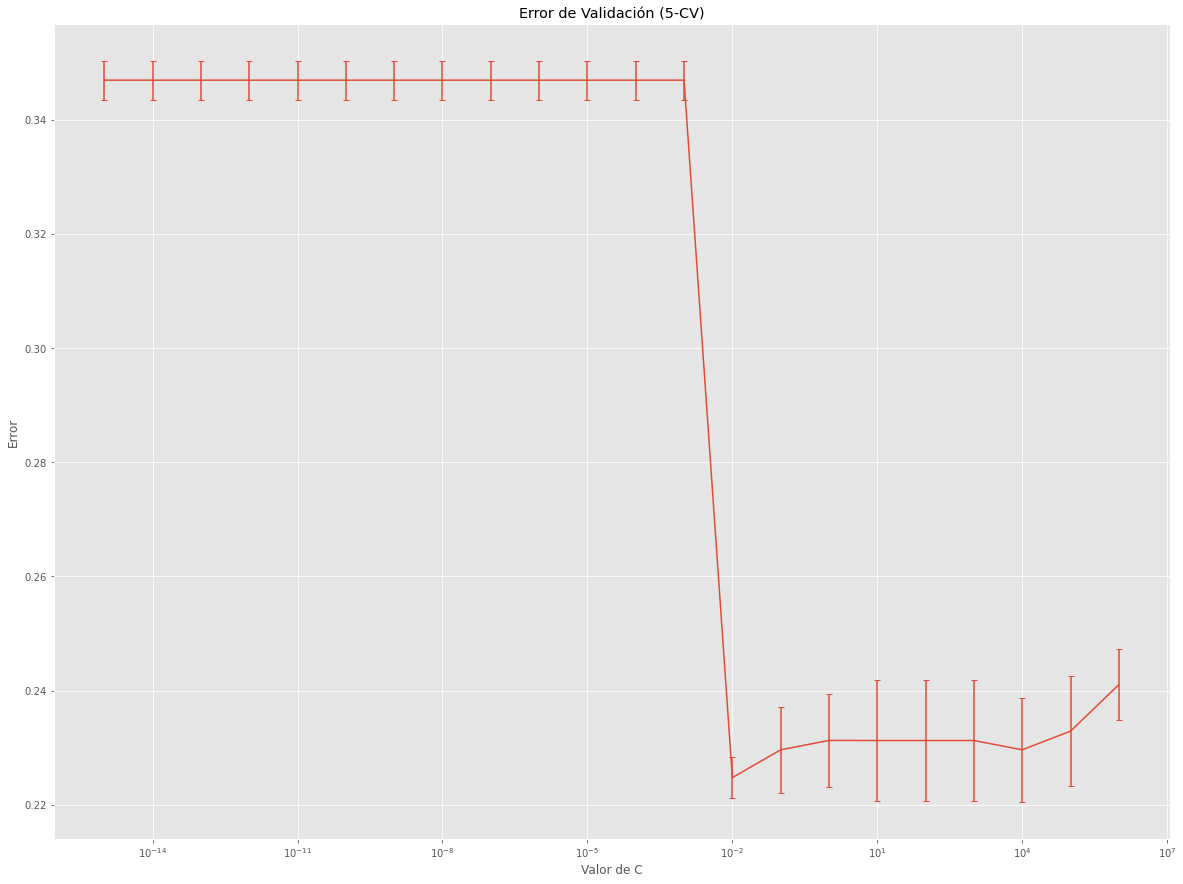

In [111]:
# Set up the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Graph
ax.set_title(f"Error de Validación (5-CV)")
ax.set_xlabel("Valor de C")
ax.set_ylabel("Error")
ax.set_xscale('log', nonposx='clip')

ax.errorbar(
    cv_results_linear['param_C'],
    cv_results_linear['mean_test_score'],
    cv_results_linear['std_test_score'],
    capsize = 3
    )
    

Como se puede ver en la gráfica superior, el error de entrenamiento alcanza su mínimo de forma muy brusca para el valor de `C` de 10e-02 y despues empieza a subir lentamente, por lo que este es su mínimo. Para valores mayores de `C` los tiempos de entrenamiento se volvían demasiado elevados.

El **menor error de validación cruzada**, **su desviación estándar** y el **hiper-parámetro para el que se consigue** es el siguiente:

In [112]:
cv_results_linear_best = cv_results_linear[cv_results_linear['rank_test_score'] == 1]

cv_results_linear_best.loc[:, [
    'param_C',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_C', 
    ascending=True
).head()


,param_C,mean_test_score,std_test_score,rank_test_score
13,0.01,0.22475,0.003588,1


**Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica del  error  de  entrenamiento  con  validación  cruzada  ha  hecho  una  buena  estimación  del  error de test**

En primer lugar, debemos calcular el error de test frente al valor del hiper-parámetro `C`:

In [113]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_pima_indians_train_Y) + [0] * len(df_pima_indians_test_Y)
ps = PredefinedSplit(test_fold = split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_pima_indians_all_X_scaled = np.vstack(
    [df_pima_indians_train_X_scaled, df_pima_indians_test_X_scaled])
df_pima_indians_all_Y = pd.concat(
    [df_pima_indians_train_Y, df_pima_indians_test_Y])

svm = SVC(random_state = SEED_VALUE)
modelCV_linear_test = GridSearchCV(
    svm,
    hyperparameters_linear,
    cv=ps,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_linear_test.fit(df_pima_indians_all_X_scaled, df_pima_indians_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                               1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
                         'kernel': ['linear']},
             return_train_score=True, scoring='accuracy')

Guardamos y mostramos los resultados por pantalla:

In [114]:
test_results_linear = pd.DataFrame(modelCV_linear_test.cv_results_)
test_results_linear['mean_test_score'] = 1 - test_results_linear['mean_test_score']

test_results_linear.loc[:, [
    'param_C',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,mean_test_score,std_test_score,rank_test_score
21,1000000,0.214286,0.0,1
19,10000,0.220779,0.0,2
18,1000,0.220779,0.0,2
17,100,0.220779,0.0,2
16,10,0.220779,0.0,2
15,1,0.220779,0.0,2
14,0.1,0.220779,0.0,2
20,100000,0.220779,0.0,2
13,0.01,0.233766,0.0,9
12,0.001,0.357143,0.0,10


En la siguiente gráfica mostraremos el error de test frente al error de entrenamiento para los diferentes valores del hiper-parámetro `C`:

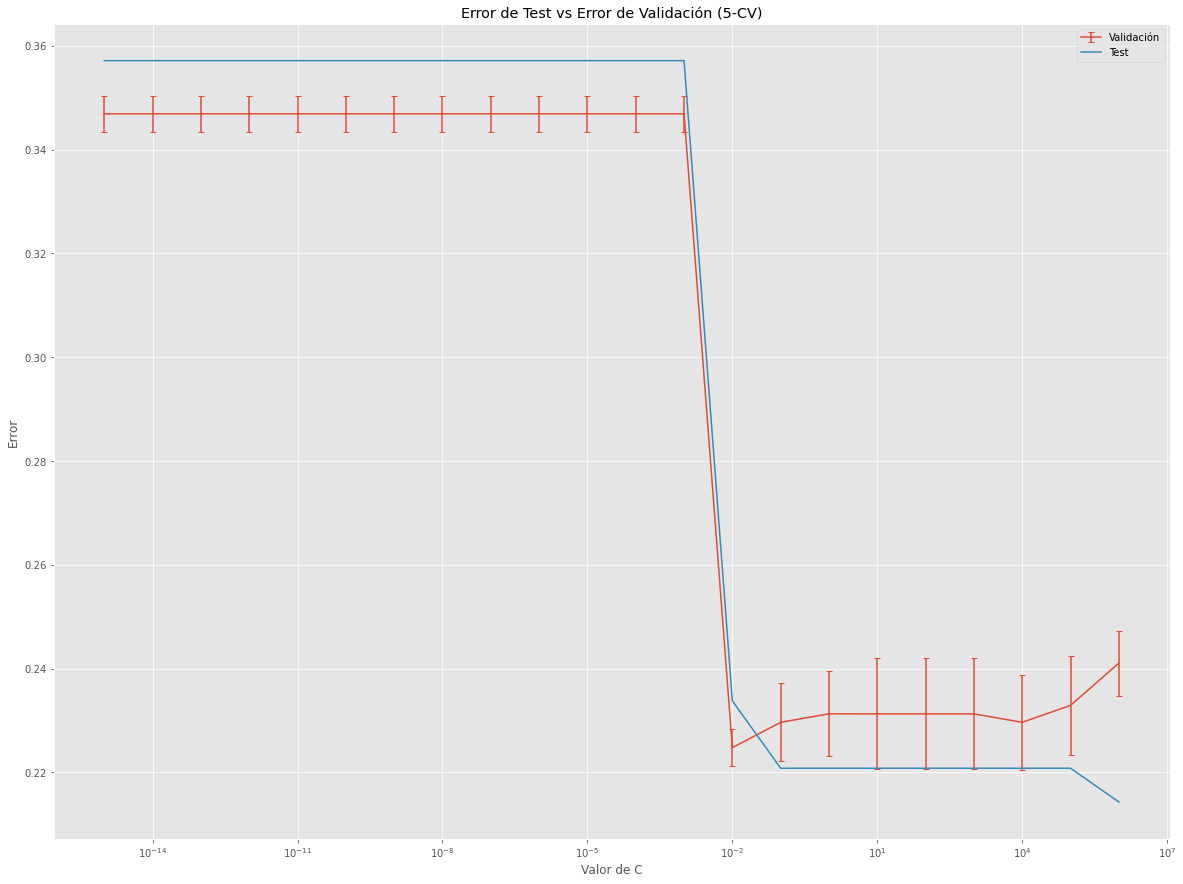

In [115]:
# Set up the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Graph
ax.set_title("Error de Test vs Error de Validación (5-CV)")
ax.set_xlabel("Valor de C")
ax.set_ylabel("Error")
ax.set_xscale('log', nonposx='clip')

ax.errorbar(
    cv_results_linear['param_C'],
    cv_results_linear['mean_test_score'],
    cv_results_linear['std_test_score'],
    label='Validación',
    capsize = 3
    )
ax.errorbar(
    test_results_linear['param_C'],
    test_results_linear['mean_test_score'],
    label='Test',
    capsize = 3
    )

ax.legend(loc="upper right")


En este caso el error de test predice de una forma muy correcta el error de test.

**¿Cuál es el menor error de test y el valor de los hiper-parámetros para el que se consigue?**

El **menor error de test** se consigue para los siguientes valores de los hiper-parámetros:

In [116]:
test_results_linear_best = test_results_linear[test_results_linear['rank_test_score'] == 1]

test_results_linear_best.loc[:, [
    'param_C',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_C',
    ascending=True
).head()


,param_C,mean_test_score,std_test_score,rank_test_score
21,1000000,0.214286,0.0,1


**¿Cuál es el error de test para el valor de los hiper-parámetros seleccionados por la validación cruzada?**

El error de test para el valor seleccionado por la validación cruzada es:

In [117]:
# Cambiar el índice de forma acorde al resultado de la validación cruzada
test_results_cv_linear_error = float(test_results_linear.iloc[13]['mean_test_score'])
test_results_cv_linear_error


0.23376623376623373

#### Kernel 'poly'

Ejecutaremos el entrenamiento para el uso del kernel polinómico de la misma manera que lo hicimos con el dataset del Ejercicio 2. Por lo tanto, emepzaremos con una búsqueda en grano grueso para ver por dónde andan los mejores valores para los hiper-parámetros. Lo primero es definir estos mismos:

In [118]:
# Para los tres kernels
c = [10**i for i in range(-8, 4, 2)]

# Para el kernel poly
degree = range(2, 9, 2)

hyperparameters_poly = {
    'kernel': ['poly'],
    'C': c,
    'gamma': [1],
    'degree': degree
}


Ahora ejecutaremos este entrenamiento haciendo uso del **kernel 'poly'**:

In [119]:
svm = SVC(random_state = SEED_VALUE)
modelCV_poly = GridSearchCV(
    svm,
    hyperparameters_poly,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_poly.fit(df_pima_indians_train_X_scaled, df_pima_indians_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-08, 1e-06, 0.0001, 0.01, 1, 100],
                         'degree': range(2, 9, 2), 'gamma': [1],
                         'kernel': ['poly']},
             return_train_score=True, scoring='accuracy')

Después consultamos los resultados obtenidos:

In [120]:
cv_results_poly = pd.DataFrame(modelCV_poly.cv_results_)
cv_results_poly['mean_test_score'] = 1 - cv_results_poly['mean_test_score']

cv_results_poly.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
9,0.0001,4,0.304585,0.030917,1
6,1e-06,6,0.315954,0.021319,2
3,1e-08,8,0.317606,0.026901,3
10,0.0001,6,0.319219,0.006034,4
13,0.01,4,0.328948,0.041329,5
7,1e-06,8,0.328975,0.017955,6
20,100,2,0.329002,0.024578,7
16,1,2,0.330588,0.022897,8
2,1e-08,6,0.332254,0.010923,9
12,0.01,2,0.333826,0.026130,10


Podemos ver como estamos obteniendo los mejores valores para el error de entrenamiento para valores del parámetro `C` inferiores a 1. Por lo tanto, continuaremos con una búsqueda de grano más fino para valores de `C` inferiores a 10 (para tomar el siguiente valor por si acaso). Por otra parte, para el hiper-parámetro `degree` no parece tan fácil acotar el rango en el que se están produciendo los mejores resultados, por lo que utilizaremos este mismo rango pero con un gran más fino.

Ejecutamos este segundo entrenamiento a continuación:

In [121]:
# Para los tres kernels
c = [10**i for i in range(-15, 2, 1)]

# Para el kernel poly
degree = range(2, 7, 1)

hyperparameters_poly = {
    'kernel': ['poly'],
    'C': c,
    'gamma': [1],
    'degree': degree
}

svm = SVC(random_state = SEED_VALUE)
modelCV_poly = GridSearchCV(
    svm,
    hyperparameters_poly,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_poly.fit(df_pima_indians_train_X_scaled, df_pima_indians_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                               1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10],
                         'degree': range(2, 7), 'gamma': [1],
                         'kernel': ['poly']},
             return_train_score=True, scoring='accuracy')

Obteniendo el siguiente resultado:

In [122]:
cv_results_poly = pd.DataFrame(modelCV_poly.cv_results_)
cv_results_poly['mean_test_score'] = 1 - cv_results_poly['mean_test_score']

cv_results_poly.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
66,0.01,3,0.260536,0.033364,1
61,0.001,3,0.263828,0.007747,2
58,0.0001,5,0.285006,0.008531,3
53,1e-05,5,0.294749,0.023317,4
71,0.1,3,0.301213,0.049668,5
...,...,...,...,...,...
82,10,4,0.369705,0.038652,81
77,1,4,0.376196,0.011098,82
83,10,5,0.381101,0.032583,83
84,10,6,0.400680,0.032611,84


Alamcenamos el modelo para su uso posterior:

In [126]:
joblib.dump(modelCV_poly, 'models/pima_indians_poly.joblib')


['models/pima_indians_poly.joblib']

**Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor del hiper-parámetro.**

Mostramos la gráfica del error de entrenamiento frente al valor del hiper-parámetro `C`. En este caso, como estamos usando el kernel `poly` o polinomial debemos representar la gráfica frente a `C` para los valores de `degree` que consideremos más representativos. Representaremos para los 4 valores de `degree` que han dado mejores resultados:

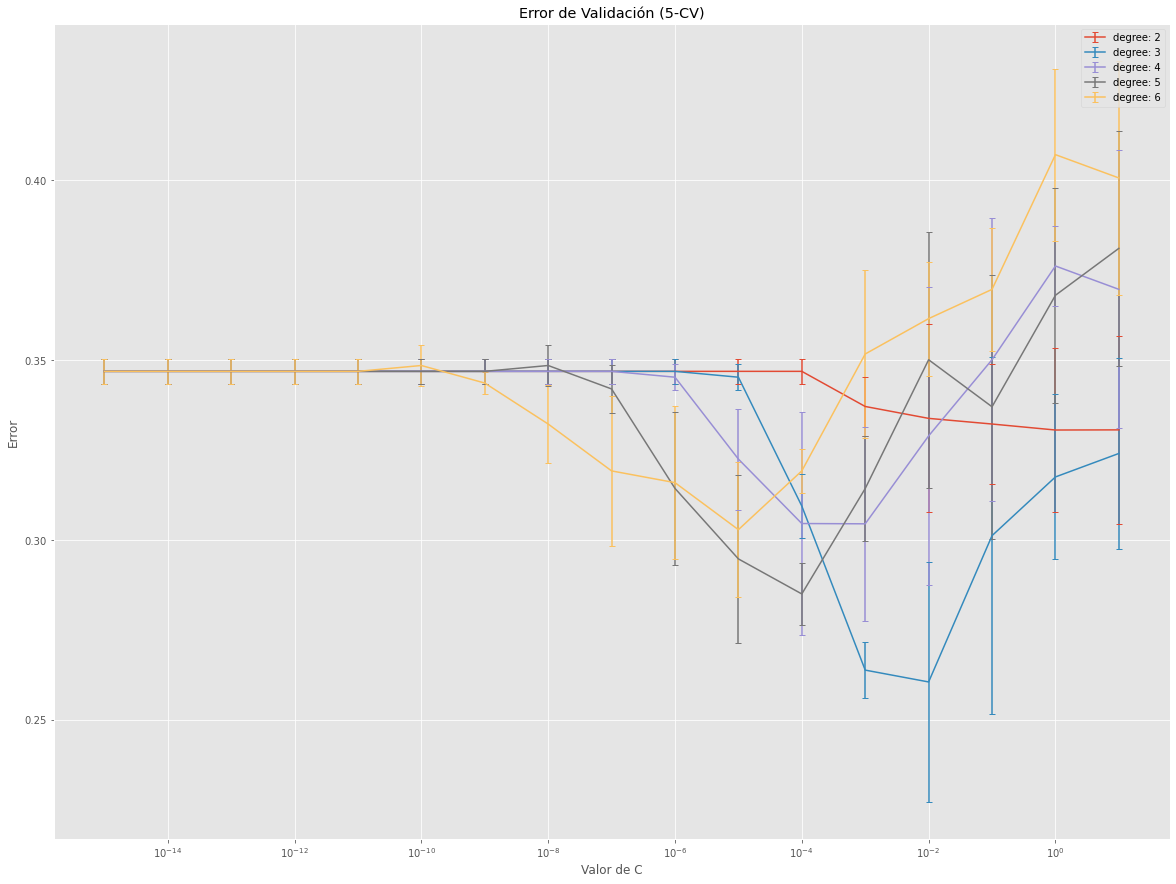

In [124]:
# Set up the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Graph
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de C")
ax.set_ylabel("Error")
ax.set_xscale('log', nonposx='clip')

# Graph for every combination of number of layers and value of alpha
for degree in hyperparameters_poly['degree']:
    cv_results_poly_degree = cv_results_poly[cv_results_poly['param_degree'] == degree]

    ax.errorbar(
        cv_results_poly_degree['param_C'],
        cv_results_poly_degree['mean_test_score'],
        cv_results_poly_degree['std_test_score'],
        label=f'degree: {degree}',
        capsize = 3
        )
    ax.legend(loc='upper right')


Como se puede observar, el menor error para el entrenamiento se alcanza para el valor del hiper-parámetro `degree` igual a 3 y para valores de `C` de entre 10e-03 y 10e-01. Después para valores mayores de `C` el error comienza a aumentar, además de que aumenta como en los casos anteriores el tiempo de entrenamiento.

Para valores mayores de `C` el modelo se volvería demasiado complejo y por lo tanto se produciría un sobre-aprendizaje de las observaciones presentes en el conjunto de entrenamiento.

El **menor error de validación cruzada**, **su desviación estándar** y el **hiper-parámetro para el que se consigue** es el siguiente:

In [125]:
cv_results_poly_best = cv_results_poly[cv_results_poly['rank_test_score'] == 1]

cv_results_poly_best.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_C', 
    ascending=True
).head()


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
66,0.01,3,0.260536,0.033364,1


**Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica del  error  de  entrenamiento  con  validación  cruzada  ha  hecho  una  buena  estimación  del  error de test**

En primer lugar, debemos calcular el error de test frente al valor de los hiper-parámetros:

In [127]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_pima_indians_train_Y) + [0] * len(df_pima_indians_test_Y)
ps = PredefinedSplit(test_fold = split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_pima_indians_all_X_scaled = np.vstack(
    [df_pima_indians_train_X_scaled, df_pima_indians_test_X_scaled])
df_pima_indians_all_Y = pd.concat(
    [df_pima_indians_train_Y, df_pima_indians_test_Y])

svm = SVC(random_state = SEED_VALUE)
modelCV_poly_test = GridSearchCV(
    svm,
    hyperparameters_poly,
    cv=ps,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_poly_test.fit(df_pima_indians_all_X_scaled, df_pima_indians_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                               1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10],
                         'degree': range(2, 7), 'gamma': [1],
                         'kernel': ['poly']},
             return_train_score=True, scoring='accuracy')

Mostramos el resultado por pantalla:

In [128]:
test_results_poly = pd.DataFrame(modelCV_poly_test.cv_results_)
test_results_poly['mean_test_score'] = 1 - test_results_poly['mean_test_score']

test_results_poly.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
66,0.01,3,0.220779,0.0,1
71,0.1,3,0.233766,0.0,2
61,0.001,3,0.240260,0.0,3
65,0.01,2,0.259740,0.0,4
76,1,3,0.259740,0.0,4
...,...,...,...,...,...
27,1e-10,4,0.357143,0.0,39
84,10,6,0.357143,0.0,39
77,1,4,0.363636,0.0,83
79,1,6,0.363636,0.0,83


En las siguiente gráficas mostramos el error de test frente al error de entrenamiento en función del valor del hiper-parámetro `C`. En cada una de las gráficas respresentaremos los resultados obtenidos para un valor específico del hiper-parámetro `degree`:

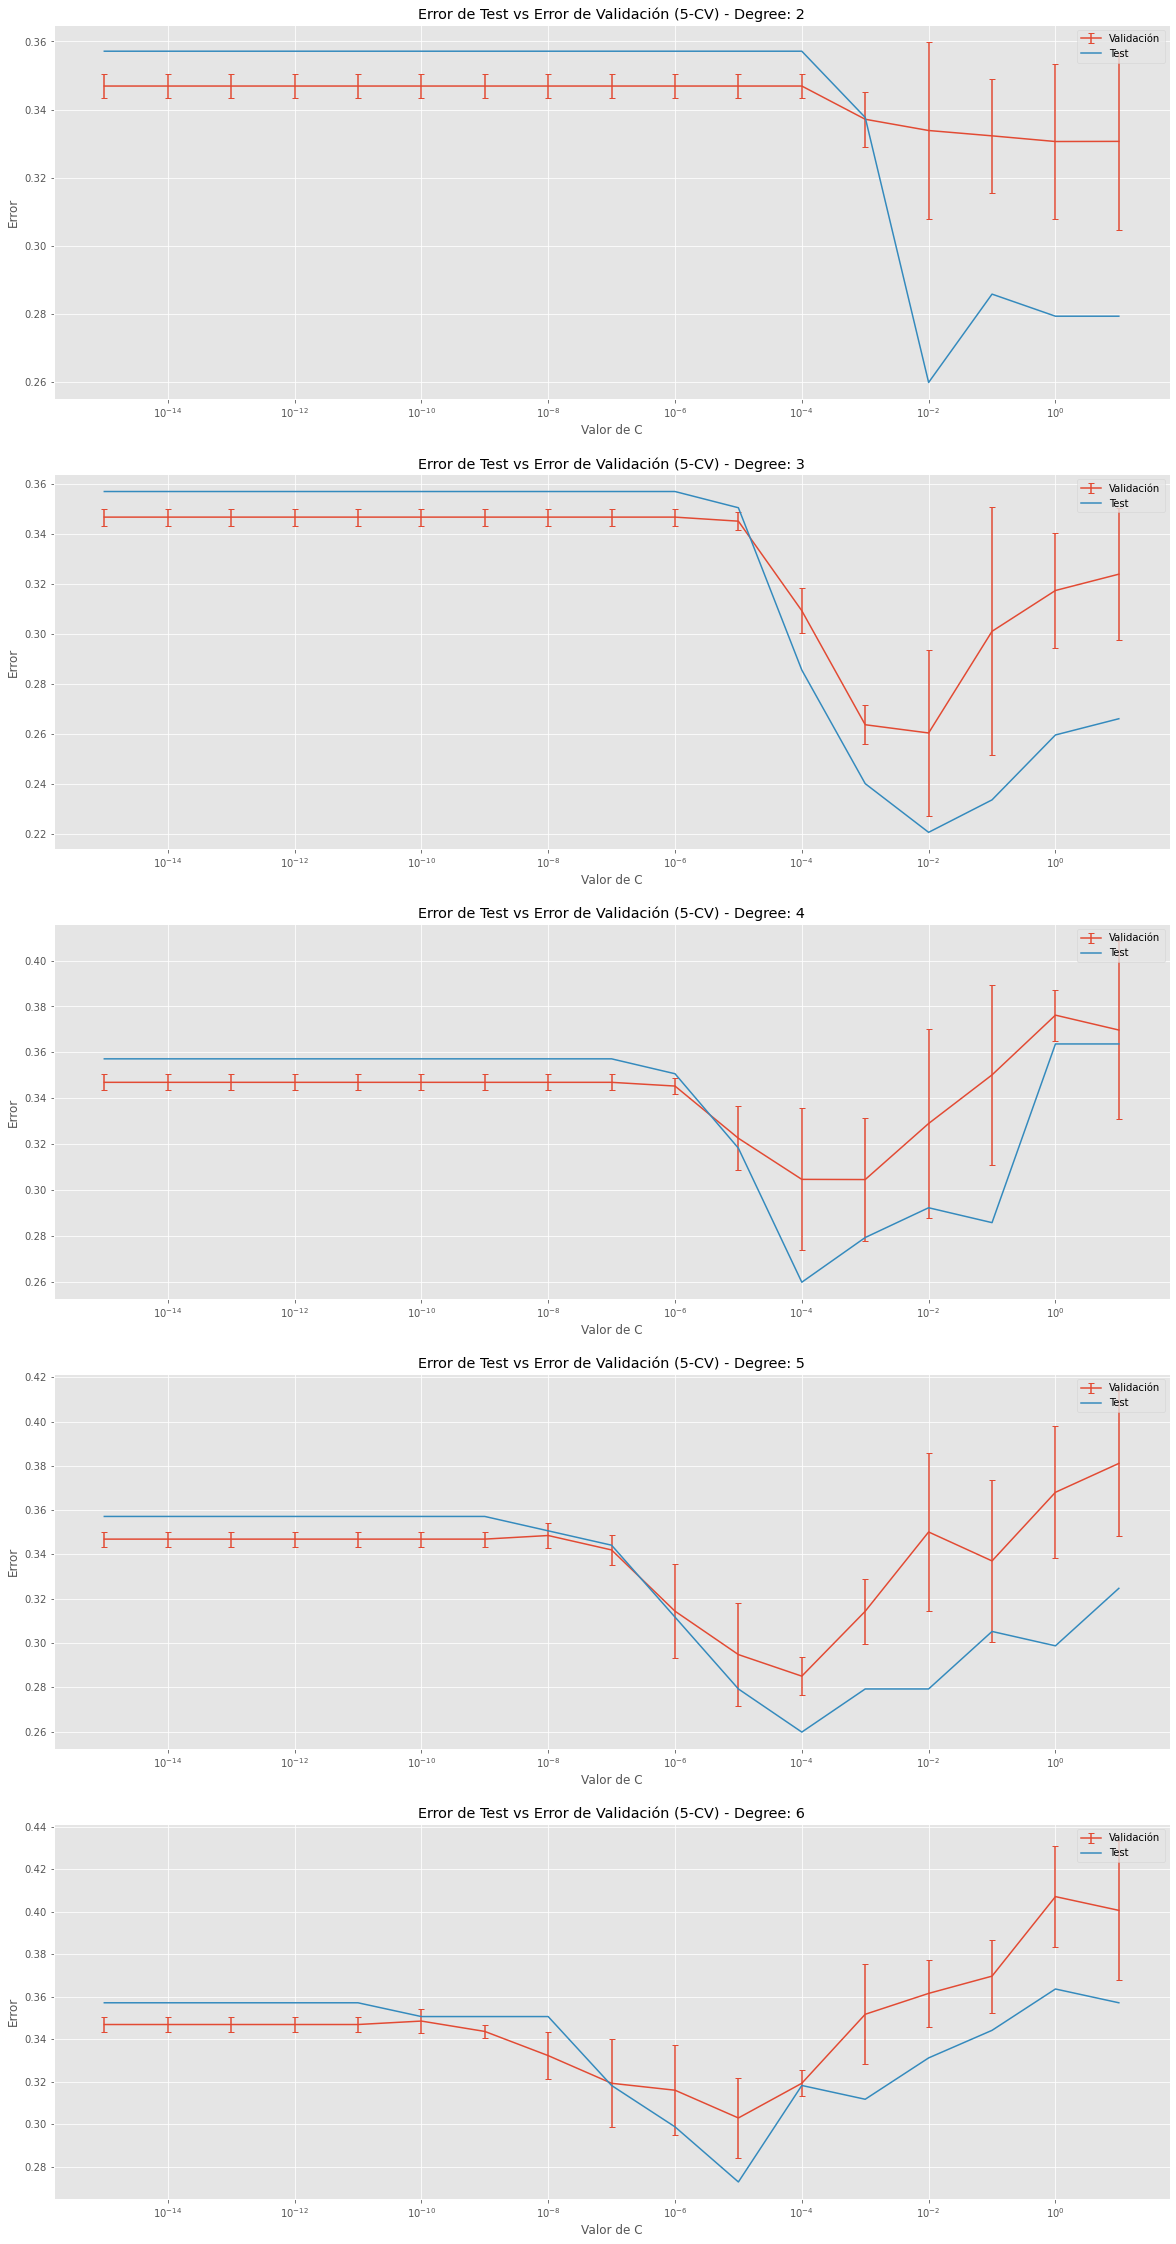

In [129]:
# Set up the graph
fig, axes = plt.subplots(figsize=(20, 40), nrows=len(hyperparameters_poly['degree']))

counter = 0

for degree in hyperparameters_poly['degree']:
    cv_results_poly_degree = cv_results_poly[cv_results_poly['param_degree'] == degree]
    test_results_poly_degree = test_results_poly[test_results_poly['param_degree'] == degree]

    # Graph
    axes[counter].set_title(f"Error de Test vs Error de Validación (5-CV) - Degree: {degree}")
    axes[counter].set_xlabel("Valor de C")
    axes[counter].set_ylabel("Error")
    axes[counter].set_xscale('log', nonposx='clip')

    axes[counter].errorbar(
        cv_results_poly_degree['param_C'],
        cv_results_poly_degree['mean_test_score'],
        cv_results_poly_degree['std_test_score'],
        label='Validación',
        capsize = 3
        )
    axes[counter].errorbar(
        test_results_poly_degree['param_C'],
        test_results_poly_degree['mean_test_score'],
        label='Test',
        capsize = 3
        )

    axes[counter].legend(loc="upper right")

    counter += 1


Para los valores de `degree` de 3 en adelante, el error de entrenamiento predice de una manera bastante acertada el error de test. Para el valor de `degree` igual a 2, se puede ver como el error de test es menor que el error de entrenamiento para los mismos valores del hiper-parámetro `C`.

**¿Cuál es el menor error de test y el valor de los hiper-parámetros para el que se consigue?**

El **menor error de test** se consigue para los siguientes valores de los hiper-parámetros:

In [130]:
test_results_poly_best = test_results_poly[test_results_poly['rank_test_score'] == 1]

test_results_poly_best.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_C',
    ascending=True
).head()


,param_C,param_degree,mean_test_score,std_test_score,rank_test_score
66,0.01,3,0.220779,0.0,1


**¿Cuál es el error de test para el valor de los hiper-parámetros seleccionados por la validación cruzada?**

El error de test para el valor seleccionado por la validación cruzada es:

In [132]:
# Cambiar el índice de forma acorde al resultado de la validación cruzada
test_results_cv_poly_error = float(test_results_poly.iloc[66]['mean_test_score'])
test_results_cv_poly_error


0.22077922077922074

#### Kernel 'rbf'

Otra vez, lo primero será definir los hiper-parámetros con los que entrenaremos para hacer uso de este kernel. Al igual que antes empezaremos con una búsqueda de grano grueso para ver en qué rango de valores para los hiper-parámetros se obtienen los mejores resultados y después haremos la búsqueda de los mejores hiper-parámetros con un grano más fino.

Definimos los hiper-parámetros:

In [133]:
# Para los tres kernels
c = [10**i for i in range(-8, 10, 2)]

# Para el kernel rbf
gamma = [10**i for i in range(-15, 6, 2)]

hyperparameters_rbf = {
    'kernel': ['rbf'],
    'C': c,
    'gamma': gamma
}

Ejecutamos el entrenamiento haciendo uso del **kernel 'rbf'**:

In [134]:
svm = SVC(random_state = SEED_VALUE)
modelCV_rbf = GridSearchCV(
    svm,
    hyperparameters_rbf,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_rbf.fit(df_pima_indians_train_X_scaled, df_pima_indians_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1e-08, 1e-06, 0.0001, 0.01, 1, 100, 10000,
                               1000000, 100000000],
                         'gamma': [1e-15, 1e-13, 1e-11, 1e-09, 1e-07, 1e-05,
                                   0.001, 0.1, 10, 1000, 100000],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

A continuación consultamos los resultados obtenidos, mostrando el ranking con los resultados de mejor a peor:

In [135]:
cv_results_rbf = pd.DataFrame(modelCV_rbf.cv_results_)
cv_results_rbf['mean_test_score'] = 1 - cv_results_rbf['mean_test_score']

cv_results_rbf.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
82,1000000,1e-05,0.221485,0.007561,1
92,100000000,1e-07,0.229615,0.012542,2
93,100000000,1e-05,0.229641,0.013964,3
61,100,0.001,0.231267,0.006359,4
81,1000000,1e-07,0.232880,0.010620,5
...,...,...,...,...,...
74,10000,10,0.348541,0.003709,95
63,100,10,0.348541,0.003709,95
96,100000000,10,0.348541,0.003709,95
85,1000000,10,0.348541,0.003709,95


Se puede ver como los mejores resultados se están dando para valores de `C` altos (superiores a 10) y valores de `gamma` pequeños (inferiores a 0,1). Por lo tanto haremos una búsqueda nueva con más detalle para estos valores: 

In [136]:
# Para los tres kernels
c = [10**i for i in range(0, 10, 1)]

# Para el kernel rbf
gamma = [10**i for i in range(-15, 2, 1)]

hyperparameters_rbf = {
    'kernel': ['rbf'],
    'C': c,
    'gamma': gamma
}

svm = SVC(random_state = SEED_VALUE)
modelCV_rbf = GridSearchCV(
    svm,
    hyperparameters_rbf,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_rbf.fit(df_pima_indians_train_X_scaled, df_pima_indians_train_Y)


GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000, 100000, 1000000,
                               10000000, 100000000, 1000000000],
                         'gamma': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10,
                                   1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

Obteniendo el resultado siguiente:

In [137]:
cv_results_rbf = pd.DataFrame(modelCV_rbf.cv_results_)
cv_results_rbf['mean_test_score'] = 1 - cv_results_rbf['mean_test_score']

cv_results_rbf.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
109,1000000,1e-08,0.216607,0.010896,1
112,1000000,1e-05,0.221485,0.007561,2
77,10000,1e-06,0.224737,0.011812,3
93,100000,1e-07,0.224737,0.010634,3
61,1000,1e-05,0.224737,0.011812,3
...,...,...,...,...,...
115,1000000,0.01,0.355005,0.036887,166
159,1000000000,1e-09,0.356484,0.119255,167
132,10000000,0.01,0.359949,0.039075,168
149,100000000,0.01,0.361575,0.038778,169


Almacenamos el modelo para su uso posterior:

In [138]:
joblib.dump(modelCV_rbf, 'models/pima_indians_rbf.joblib')


['models/pima_indians_rbf.joblib']

**Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor del hiper-parámetro.**

Mostramos la gráfica del error de entrenamiento en función del valor del hiper-parámetro `C`. Al igual que antes, representaremos la gráfica para los valores de `gamma` más representativos, es decir, para las que se obtengan los mejores resultados:

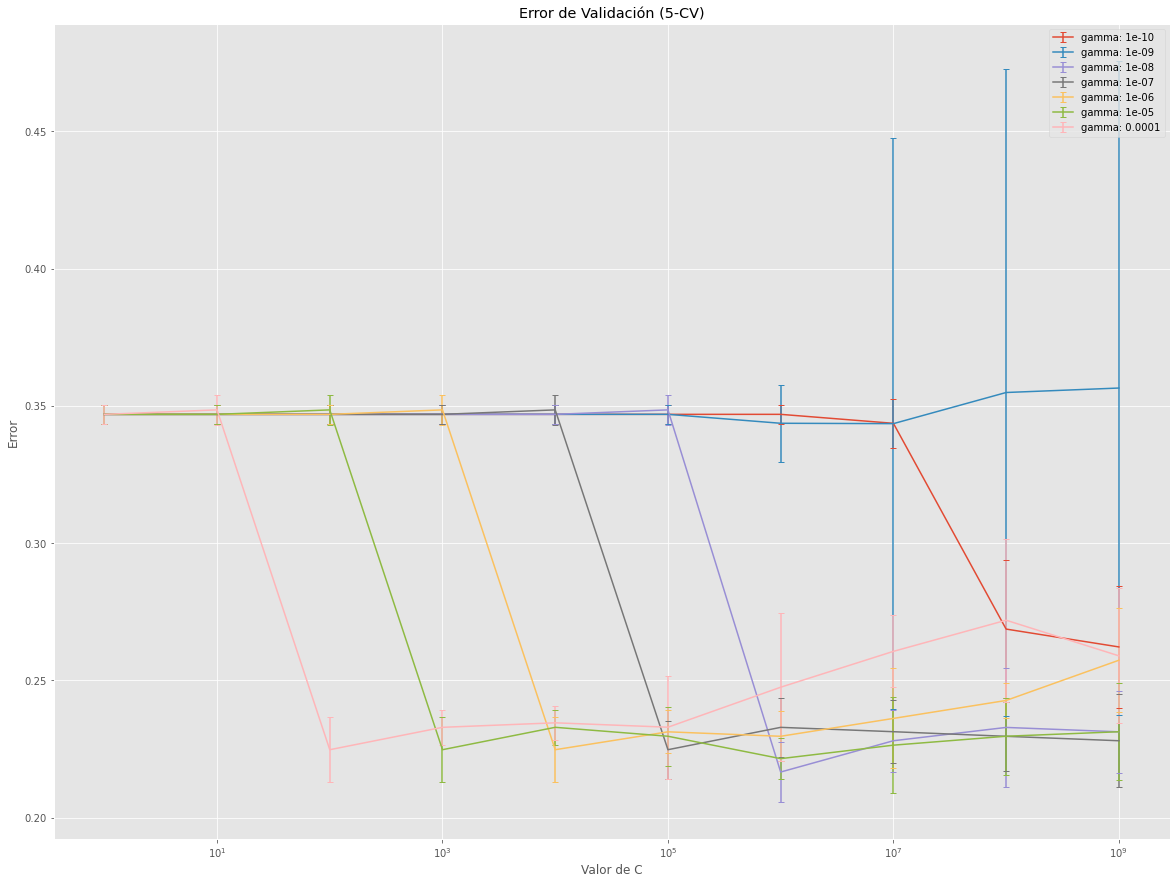

In [140]:
# Set up the graph
fig, ax = plt.subplots(figsize=(20, 15))

# Graph
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de C")
ax.set_ylabel("Error")
ax.set_xscale('log', nonposx='clip')

# Graph for every combination of number of layers and value of alpha
for gamma in [10**i for i in range(-10, -3, 1)]:
    cv_results_rbf_gamma = cv_results_rbf[cv_results_rbf['param_gamma'] == gamma]

    ax.errorbar(
        cv_results_rbf_gamma['param_C'],
        cv_results_rbf_gamma['mean_test_score'],
        cv_results_rbf_gamma['std_test_score'],
        label=f'gamma: {gamma}',
        capsize = 3
        )
    ax.legend(loc='upper right')


En la gráfica superior podemos ver como para los distintos valores de `gamma` entre 1e-04 y 1e-08 los errores de entrenamiento son relativamente altos y después sufren una caída considerable para algún valor de `C`. Después a medida que sube ese valor de `C` los errores de entrenamiento suben ligeramente y se mantienen estables. Esto probablemente sea debido a una situación de sobre-aprendizaje para estos valores mayores de `C`.

Para los valores de `gamma` iguales o inferiores a 1e-09 esta bajada en el error de entrenamiento no llega a ocurrir para ningún valor de `C`, por lo que su rendimiento es peor.

Por lo tanto nos quedaremos con la mejor combinación de los hiper-parámetros de entre las que se muestran en la gráfica superior.

El **menor error de validación cruzada**, **su desviación estándar** y el **hiper-parámetro para el que se consigue** es el siguiente:

In [141]:
cv_results_rbf_best = cv_results_rbf[cv_results_rbf['rank_test_score'] == 1]

cv_results_rbf_best.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_C', 
    ascending=True
).head()


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
109,1000000,1e-08,0.216607,0.010896,1


**Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica del  error  de  entrenamiento  con  validación  cruzada  ha  hecho  una  buena  estimación  del  error de test**

En primer lugar, debemos calcular el error de test frente al valor de los hiper-parámetros:

In [142]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_pima_indians_train_Y) + [0] * len(df_pima_indians_test_Y)
ps = PredefinedSplit(test_fold = split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_pima_indians_all_X_scaled = np.vstack(
    [df_pima_indians_train_X_scaled, df_pima_indians_test_X_scaled])
df_pima_indians_all_Y = pd.concat(
    [df_pima_indians_train_Y, df_pima_indians_test_Y])

svm = SVC(random_state = SEED_VALUE)
modelCV_rbf_test = GridSearchCV(
    svm,
    hyperparameters_rbf,
    cv=ps,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_rbf_test.fit(df_pima_indians_all_X_scaled, df_pima_indians_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000, 100000, 1000000,
                               10000000, 100000000, 1000000000],
                         'gamma': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10,
                                   1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

Mostramos los resultados por pantalla:

In [143]:
test_results_rbf = pd.DataFrame(modelCV_rbf_test.cv_results_)
test_results_rbf['mean_test_score'] = 1 - test_results_rbf['mean_test_score']

test_results_rbf.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
113,1000000,0.0001,0.181818,0.0,1
164,1000000000,0.0001,0.194805,0.0,2
147,100000000,0.0001,0.194805,0.0,2
97,100000,0.001,0.194805,0.0,2
114,1000000,0.001,0.201299,0.0,5
...,...,...,...,...,...
51,1000,1e-15,0.357143,0.0,86
50,100,10,0.357143,0.0,86
43,100,1e-06,0.357143,0.0,86
41,100,1e-08,0.357143,0.0,86


En las siguientes gráficas mostramos el error de test frente al error de entrenamiento en función del valor del hiper-parámetro `C`. En cada una de ellas representaremos los resultados para los valores del hiper-parámetro `gamma` más representativos (entre 1e-08 y 1e-02):

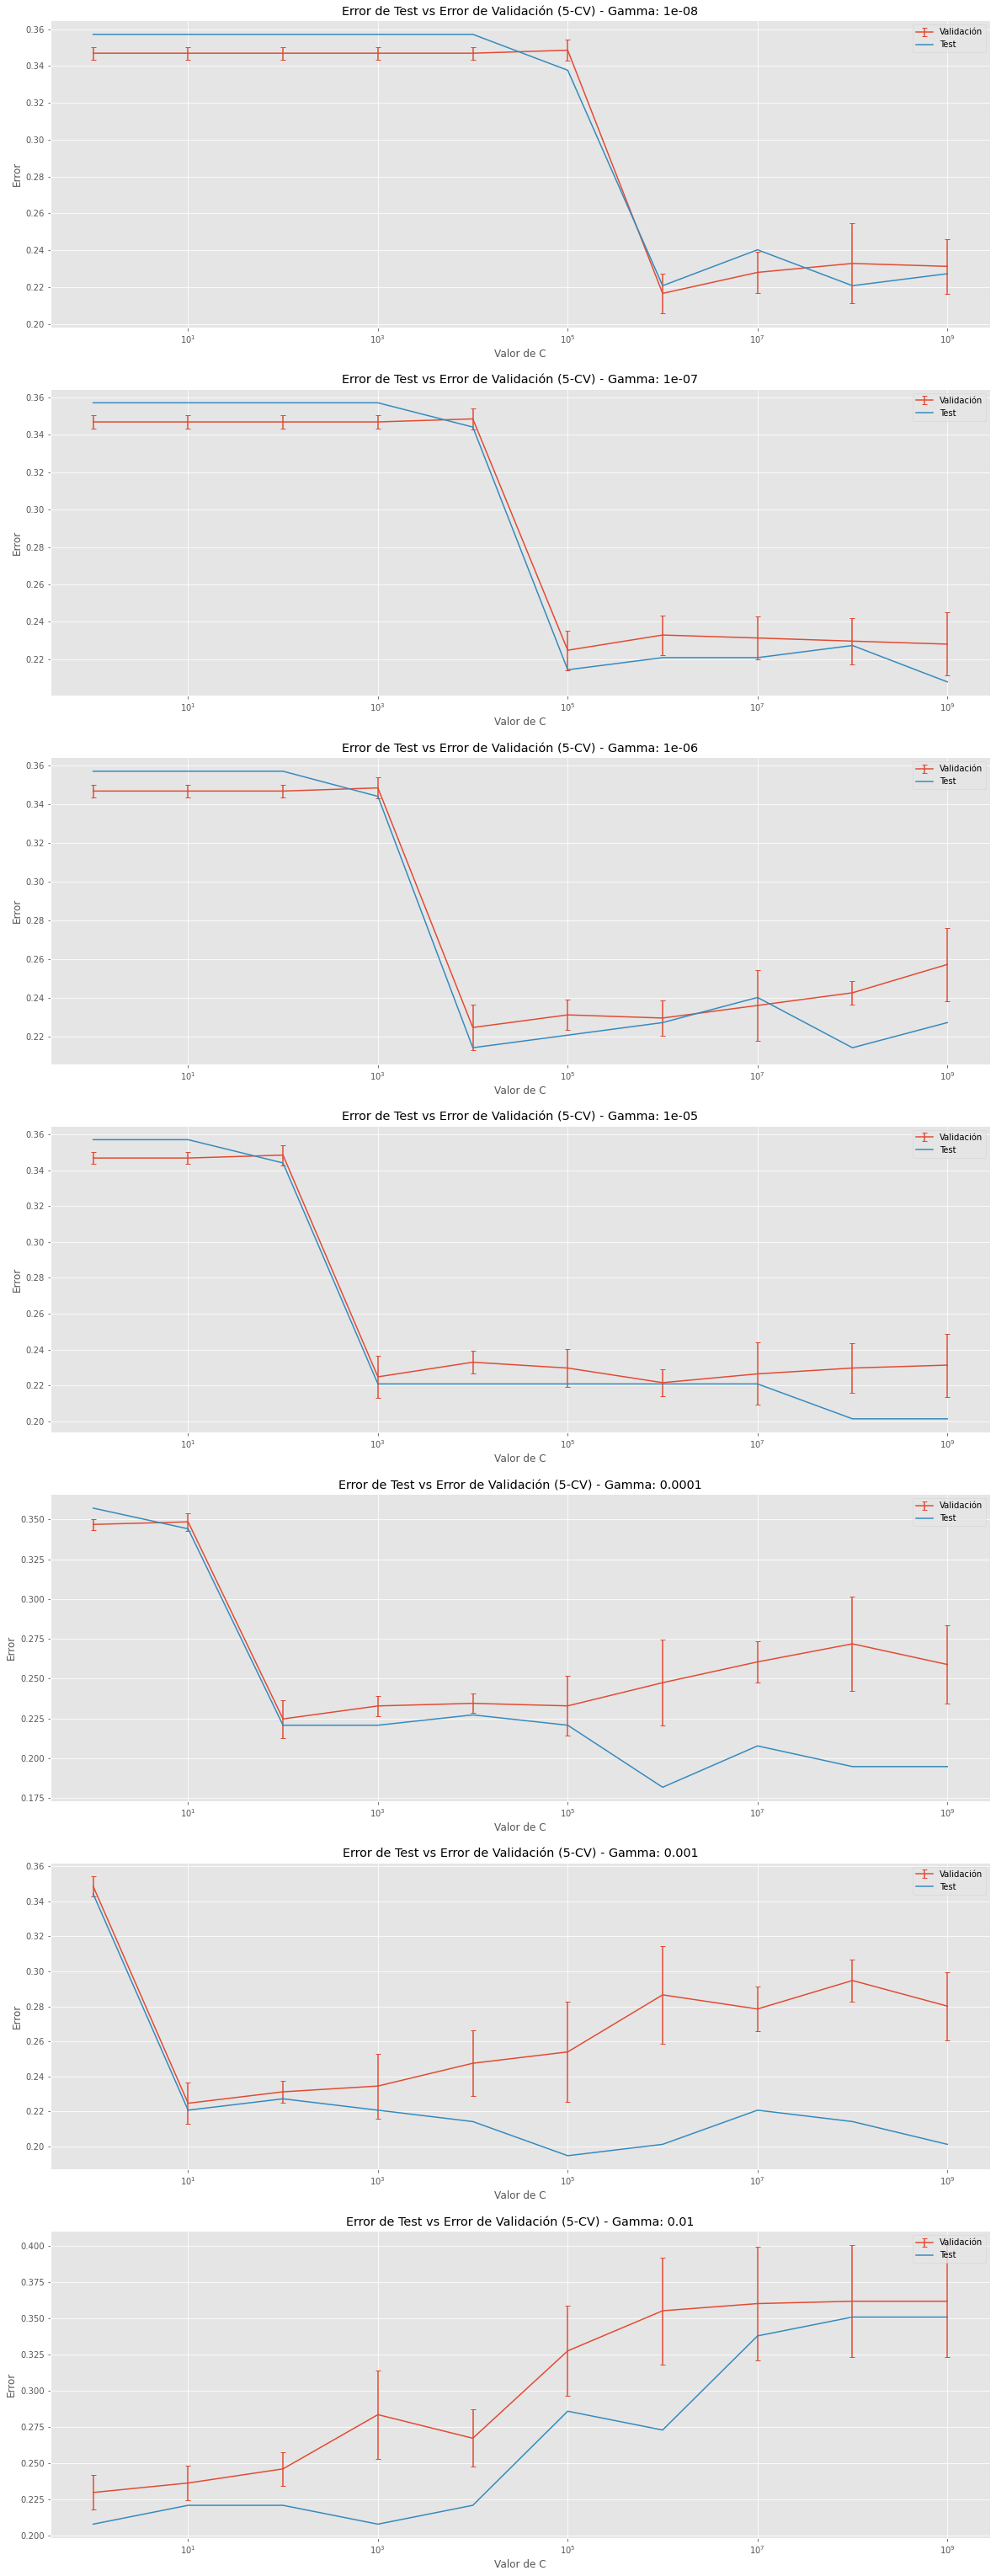

In [144]:
gammas_to_plot = [10**i for i in range(-8, -1, 1)]

# Set up the graph
fig, axes = plt.subplots(figsize=(20, 55), nrows=len(gammas_to_plot))

counter = 0

for gamma in gammas_to_plot:
    cv_results_rbf_gamma = cv_results_rbf[cv_results_rbf['param_gamma'] == gamma]
    test_results_rbf_gamma = test_results_rbf[test_results_rbf['param_gamma'] == gamma]

    # Graph
    axes[counter].set_title(f"Error de Test vs Error de Validación (5-CV) - Gamma: {gamma}")
    axes[counter].set_xlabel("Valor de C")
    axes[counter].set_ylabel("Error")
    axes[counter].set_xscale('log', nonposx='clip')

    axes[counter].errorbar(
        cv_results_rbf_gamma['param_C'],
        cv_results_rbf_gamma['mean_test_score'],
        cv_results_rbf_gamma['std_test_score'],
        label='Validación',
        capsize = 3
        )
    axes[counter].errorbar(
        test_results_rbf_gamma['param_C'],
        test_results_rbf_gamma['mean_test_score'],
        label='Test',
        capsize = 3
        )

    axes[counter].legend(loc="upper right")

    counter += 1


Como se puede ver, el error de entrenamiento sí que aproxima de forma correcta el error de test, sobre todo para los valores del hiper-parámetro `gamma` inferiores a 1e-04. 

**¿Cuál es el menor error de test y el valor de los hiper-parámetros para el que se consigue?**

El **menor error de test** se consigue para los siguientes valores de los hiper-parámetros:

In [145]:
test_results_rbf_best = test_results_rbf[test_results_rbf['rank_test_score'] == 1]

test_results_rbf_best.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_C',
    ascending=True
).head()


,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
113,1000000,0.0001,0.181818,0.0,1


**¿Cuál es el error de test para el valor de los hiper-parámetros seleccionados por la validación cruzada?**

In [146]:
# Cambiar el índice de forma acorde al resultado de la validación cruzada
test_results_cv_rbf_error = float(test_results_rbf.iloc[109]['mean_test_score'])
test_results_cv_rbf_error


0.22077922077922074